## Data Collection

The data used in this report was pulled from TMDB (https://www.themoviedb.org) using their public API. To be able to use the API, we created a user and sent a GET request to the authentications endpoint (https://api.themoviedb.org/3/authentication). By doing this, we were able to confirm proper client setup. Furthermore, we conducted GET requests to the endpoint (https://api.themoviedb.org/3/discover/movie) to get as many records as possible. We stored those records in CSV format.

The data collected has the following features:

GenreIds: This is a list of different genres applicable to the movie. The map between genre id and genre is below:

- Action          28
- Adventure       12
- Animation       16
- Comedy          35
- Crime           80
- Documentary     99
- Drama           18
- Family          10751
- Fantasy         14
- History         36
- Horror          27
- Music           10402
- Mystery         9648
- Romance         10749
- Science Fiction 878
- TV Movie        10770
- Thriller        53
- War             10752
- Western         37

Id: this is the unique identifier for each movie
OriginalLanguage: The movie's original language
OriginalTitle: The movie's title
Overview: short description of the movie content
Popularity: it is a metric used to measure how popular the movie is, it takes into account the following aspects

- Number of votes for the day
- Number of views for the day
- Number of users who marked it as a "favorite" for the day
- Number of users who added it to their "watchlist" for the day
- Release date
- Number of total votes
- Previous days score

ReleaseDate: movie data of release
Title: title of the movie
VoteAverage: It's the average of all of the TMDb user ratings
VoteCount: number of people who voted for the movie

In [1]:
# Import libraries
import seaborn as sns
import numpy as np
import ast
import csv
import os
import pandas as pd
import requests
import warnings
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS
import nltk
import spacy
import warnings
warnings.filterwarnings('ignore')
pyLDAvis.enable_notebook()
import string
import re
import emoji
# nltk.download('omw-1.4')
# ! pip install contractions
import contractions
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# # Checking API Authentication
# api_token = os.environ['API_TMDB_TOKEN']

# url = "https://api.themoviedb.org/3/authentication"

# headers = {
#     "accept": "application/json",
#     "Authorization": f"Bearer {api_token}"
# }

# response = requests.get(url, headers=headers)

# print(response.text)

In [4]:
# Funtions to handle the data retrieval

def create_dict(data):
    '''This funtion creates a list of dictionaries from the request response'''
    result = {}
    movies = []
    for movie in data:
        result['GenreIds'] = movie.get('genre_ids', None)
        result['Id'] = movie.get('id', None)
        result['OriginalLanguage'] = movie.get('original_language', None)
        result['OriginalTitle'] = movie.get('original_title', None)
        result['Overview'] = movie.get('overview', None)
        result['Popularity'] = movie.get('popularity', None)
        result['ReleaseDate'] = movie.get('release_date', None)
        result['Title'] = movie.get('title', None)
        result['VoteAverage'] = movie.get('vote_average', None)
        result['VoteCount'] = movie.get('vote_count', None)
        movies.append(result)
        result = {}
    return movies

def store_in_CSV(file_name, posts, fields):
    '''This function stores a list of dictionaries in CSV format'''
    with open(file_name, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields)
        if csvfile.tell() == 0:
            writer.writeheader()
        writer.writerows(posts)

def retrive_movies_data(headers):
    '''This function retrieves data form the /discover endpoint and process it into a CSV file'''
    page = 1
    url = "https://api.themoviedb.org/3/discover/movie?include_adult=false&include_video=false&language=en-US&sort_by=popularity.desc"
    fields = ['GenreIds', 'Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity', 'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount']

    while True:
        final_url = url + f"&page={page}"
        res = requests.get(final_url, headers=headers)
        json_res = res.json()
        data = json_res.get("results", [])
        if len(data) == 0:
            break
        dic_data = create_dict(data)
        page += 1
        store_in_CSV('movies.csv',dic_data, fields)

def create_movie_dict(data):
    '''This funtion creates a list of dictionaries from the request response'''
    result = {}
    movies = []
    for movie in data:
        result['Id'] = movie.get('id', None)
        result['Budget'] = movie.get('budget', None)
        result['ProductionCompanies'] = movie.get('production_companies', None)
        result['ProductionCountries'] = movie.get('production_countries', None)
        result['SpokenLanguages'] = movie.get('spoken_languages', None)
        result['TagLine'] = movie.get('tagline', None)
        result['RunTime'] = movie.get('runtime', None)
        result['Revenue'] = movie.get('revenue', None)
        movies.append(result)
        result = {}
    return movies


def get_data_by_id(headers, ids):
    '''This function retrieves data form the /movie/id endpoint and process it into a CSV file'''
    url = 'https://api.themoviedb.org/3/movie/'
    fields = ['Id', 'Budget', 'ProductionCompanies', 'ProductionCountries', 'SpokenLanguages', 'TagLine', 'RunTime', 'Revenue']
    all_movies = []

    for id in ids:
        final_url = url + f"{id}"
        res = requests.get(final_url, headers=headers)
        json_res = res.json()
        all_movies.append(json_res)
    dic_data = create_movie_dict(all_movies)
    store_in_CSV('movie_details.csv',dic_data, fields)

In [5]:
# running this function creates a movies.csv in the same folder
# retrive_movies_data(headers)

In [6]:
# Initial Dataset review
df_init = pd.read_csv('movies.csv')
print(df_init.shape)
df_init.head()

(10000, 10)


,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364
1,"[28, 53, 80]",926393,en,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027
2,"[16, 28, 14]",1034062,en,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27
3,"[28, 53]",575264,en,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799
4,"[53, 18]",1151534,es,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686


In [7]:
# getting the list of movie ids
ids = list(df_init['Id'])

In [8]:
# getting second dataset with movie details
# get_data_by_id(headers, ids)

In [9]:
# Chencking movie details data

df_movies = pd.read_csv('movie_details.csv')
print(df_movies.shape)
df_movies.head()

(10000, 8)


,Id,Budget,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine,RunTime,Revenue
0,299054,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.,103,30000000
1,926393,70000000,"[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6...","[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...","[{'english_name': 'English', 'iso_639_1': 'en'...",Justice knows no borders.,109,176933602
2,1034062,0,"[{'id': 2785, 'logo_path': '/l5zW8jjmQOCx2dFmv...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",Neon lights... Suits with shoulder pads... Jum...,80,0
3,575264,291000000,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'French', 'iso_639_1': 'fr',...",We all share the same fate.,164,567148955
4,1151534,0,"[{'id': 204005, 'logo_path': None, 'name': 'Ro...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]","[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Attempting to survive in the middle of nowhere...,109,0


## Data Wrangling

In this section, we conducted several steps to clean up and prepare the data for analysis. The steps we followed are listed below:

1. Merge data sets: So far, we have two CSV files, one with overall movie information and one with detailed movie data. We wanted to merge these two datasets using the movie "Id" as the primary key.
2. Features and datatypes: In this steps we will process features into the proper data type, inspecting and correcting invalid values
3. Inspect and impute nulls
4. Inspect and correct duplicated rows
5. create a new cleaned dataset (movies_cleaned.csv)



### 1. Merge Datasets

In [10]:
def inner_join(df1, df2, pk):
    '''This methods performs inner joint, based on given primery key'''
    return pd.merge(df1, df2, on=pk)

In [11]:
# Perform inner join to consolidate one single dataset
df = inner_join(df_init, df_movies, 'Id')
print(df.shape)
df.head(1)

(10000, 17)


,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine,RunTime,Revenue
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.,103,30000000


### 2. Features and datatypes:

In [12]:
# create a list with the columns of the Dataframe
columns = df.columns

In [13]:
# Review the dataframe datatypes

df.dtypes

GenreIds                object
Id                       int64
OriginalLanguage        object
OriginalTitle           object
Overview                object
Popularity             float64
ReleaseDate             object
Title                   object
VoteAverage            float64
VoteCount                int64
Budget                   int64
ProductionCompanies     object
ProductionCountries     object
SpokenLanguages         object
TagLine                 object
RunTime                  int64
Revenue                  int64
dtype: object

In [14]:
# correcting the datetype for the column ReleaseDate

df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])

In [15]:
# categorical columns inspection

categorical_df = df.select_dtypes(include='object')
categorical_df.head(1)

,GenreIds,OriginalLanguage,OriginalTitle,Overview,Title,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine
0,"[28, 12, 53]",en,Expend4bles,Armed with every weapon they can get their han...,Expend4bles,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.


In [16]:
# reviewing unique values in each category to stablish category relevancy, text columns excluded to process in further steps

categorical_columns = categorical_df.columns
text_columns = ['Overview', 'Title', 'OriginalTitle', 'TagLine']

for column in categorical_columns:
    if column not in text_columns:
        print(f"----Unique values for column {column} -----")
        print(categorical_df[column].unique()[:5])

----Unique values for column GenreIds -----
['[28, 12, 53]' '[28, 53, 80]' '[16, 28, 14]' '[28, 53]' '[53, 18]']
----Unique values for column OriginalLanguage -----
['en' 'es' 'ko' 'hi' 'de']
----Unique values for column ProductionCompanies -----
["[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLghDhhZJzHZTd.png', 'name': 'Millennium Media', 'origin_country': 'US'}, {'id': 48738, 'logo_path': None, 'name': 'Campbell Grobman Films', 'origin_country': 'US'}, {'id': 1632, 'logo_path': '/cisLn1YAUuptXVBa0xjq7ST9cH0.png', 'name': 'Lionsgate', 'origin_country': 'US'}]"
 "[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6HWEn1YqfAV.png', 'name': 'Escape Artists', 'origin_country': 'US'}, {'id': 5, 'logo_path': '/wrweLpBqRYcAM7kCSaHDJRxKGOP.png', 'name': 'Columbia Pictures', 'origin_country': 'US'}, {'id': 10400, 'logo_path': '/9LlB2YAwXTkUAhx0pItSo6pDlkB.png', 'name': 'Eagle Pictures', 'origin_country': 'IT'}, {'id': 44967, 'logo_path': None, 'name': 'ZHIV Productions', 'origin_country': ''}]"
 "[{'i

In [17]:
# eliminate SpokenLanguages as there is already a column for original language and we believe the translations may not be predictive to the model
df.drop('SpokenLanguages', axis=1, inplace=True)

In [18]:
df.head()

,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,ProductionCompanies,ProductionCountries,TagLine,RunTime,Revenue
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...",They'll die when they're dead.,103,30000000
1,"[28, 53, 80]",926393,en,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027,70000000,"[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6...","[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...",Justice knows no borders.,109,176933602
2,"[16, 28, 14]",1034062,en,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27,0,"[{'id': 2785, 'logo_path': '/l5zW8jjmQOCx2dFmv...","[{'iso_3166_1': 'US', 'name': 'United States o...",Neon lights... Suits with shoulder pads... Jum...,80,0
3,"[28, 53]",575264,en,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799,291000000,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...","[{'iso_3166_1': 'US', 'name': 'United States o...",We all share the same fate.,164,567148955
4,"[53, 18]",1151534,es,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686,0,"[{'id': 204005, 'logo_path': None, 'name': 'Ro...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]",Attempting to survive in the middle of nowhere...,109,0


In [19]:
# preprocessing of column 'GenreIds'

# We created the new columns in the DataFrame, one column per genre (one-hot encoding)

genre_map = {
    28: 'Action',
    12: 'Adventure',
    16: 'Animation',
    35: 'Comedy',
    80: 'Crime',
    99: 'Documentary',
    18: 'Drama',
    10751: 'Family',
    14: 'Fantasy',
    36: 'History ',
    27: 'Horror',
    10402: 'Music',
    9648: 'Mystery',
    10749: 'Romance',
    878: 'ScienceFiction',
    10770: 'TvMovie',
    53: 'Thriller',
    10752: 'War',
    37: 'Western'
}

In [20]:
import ast

# Assuming you have a DataFrame called 'df' with a column 'GenreIds'
# Convert the string representation of list to an actual list
df['GenreIds'] = df['GenreIds'].apply(ast.literal_eval)

# Function to map genre IDs to names
def map_genre_ids_to_names(genre_ids):
    return [genre_map.get(genre_id, genre_id) for genre_id in genre_ids]

# Apply the mapping function to the 'GenreIds' column
df['Genres'] = df['GenreIds'].apply(map_genre_ids_to_names)

In [21]:
df['Genres'] = df['Genres'].apply(lambda x: ', '.join(x))

In [22]:
df['Genres']

0       Action, Adventure, Thriller
1           Action, Thriller, Crime
2        Animation, Action, Fantasy
3                  Action, Thriller
4                   Thriller, Drama
                   ...             
9995        Action, Crime, Thriller
9996        Drama, Action, Thriller
9997                  Drama, Comedy
9998                          Drama
9999     Music, Documentary, Family
Name: Genres, Length: 10000, dtype: object

In [23]:
# dropping the GenreIds
df.drop('GenreIds', axis=1, inplace=True)

Processing of ProductionCompanies and ProductionCountries

In [24]:
# Function create a mapping object
def get_feature_mapper(df, column):
    '''This functions creates an object to map the categorical name to the rows'''
    result = {}
    for i in range(len(df)):
        items = ast.literal_eval(df.loc[i, column])
        for item in items:
            name = item['name']
            if name in result.keys():
                result[name].append(i)
            else:
                result[name] = []
    return result

In [25]:
# checking the cardinality for the column ProductionCompanies
prod_comp_map = get_feature_mapper(df, 'ProductionCompanies')
len(prod_comp_map.keys())

9980

The cardinality for the column ProductionCompanies is high, with 9980 different production companies. Therefore, we won't consider this column as it might not be discriminative enough.

In [26]:
# eliminating the column ProductionCompanies
df.drop('ProductionCompanies', axis=1, inplace=True)

In [27]:
# checking the cardinality for the column ProductionCountries
prod_contries_map = get_feature_mapper(df, 'ProductionCountries')
len(prod_contries_map.keys())

107

In [28]:
prod_contries_map.keys()

dict_keys(['United States of America', 'Italy', 'Spain', 'South Korea', 'China', 'India', 'Canada', 'France', 'Australia', 'United Kingdom', 'Germany', 'Brazil', 'Mexico', 'Japan', 'Russia', 'Sweden', 'United Arab Emirates', 'Nigeria', 'Poland', 'Serbia', 'Ukraine', 'Thailand', 'Finland', 'Norway', 'Switzerland', 'Bangladesh', 'Austria', 'Kazakhstan', 'Belgium', 'Hong Kong', 'Cyprus', 'Greece', 'Denmark', 'Ireland', 'New Zealand', 'Chile', 'Philippines', 'Singapore', 'Taiwan', 'Puerto Rico', 'Iceland', 'Argentina', 'Czech Republic', 'Colombia', 'Peru', 'Bulgaria', 'Netherlands', 'Hungary', 'South Africa', 'Latvia', 'Dominican Republic', 'Uruguay', 'Venezuela', 'Malta', 'Turkey', 'Saudi Arabia', 'Portugal', 'Morocco', 'Slovenia', 'Israel', 'Luxembourg', 'Indonesia', 'Panama', 'Bolivia', 'Romania', 'Guadaloupe', 'Iran', 'Costa Rica', 'Honduras', 'Albania', 'Jordan', 'Pakistan', 'Lithuania', 'Vietnam', 'Malawi', 'Soviet Union', 'Estonia', 'Botswana', 'Paraguay', 'Yugoslavia', 'Georgia', '

The column ProductionCountries had high cardinality (107). On the other hand, we considered this column to be meaningful to the model. Therefore, we decided to reduce the number of columns by creating groups of production countries based on continents.

In [29]:
country_region = {
    'United States of America': 'North America',
    'Italy': 'Europe',
    'Spain': 'Europe',
    'South Korea': 'Asia',
    'China': 'Asia',
    'India': 'Asia',
    'Canada': 'North America',
    'France': 'Europe',
    'Australia': 'Oceania',
    'United Kingdom': 'Europe',
    'Germany': 'Europe',
    'Brazil': 'South America',
    'Mexico': 'North America',
    'Japan': 'Asia',
    'Russia': 'Europe',
    'Sweden': 'Europe',
    'United Arab Emirates': 'Asia',
    'Nigeria': 'Africa',
    'Poland': 'Europe',
    'Serbia': 'Europe',
    'Ukraine': 'Europe',
    'Thailand': 'Asia',
    'Finland': 'Europe',
    'Norway': 'Europe',
    'Switzerland': 'Europe',
    'Bangladesh': 'Asia',
    'Austria': 'Europe',
    'Kazakhstan': 'Asia',
    'Belgium': 'Europe',
    'Hong Kong': 'Asia',
    'Cyprus': 'Europe',
    'Greece': 'Europe',
    'Denmark': 'Europe',
    'Ireland': 'Europe',
    'New Zealand': 'Oceania',
    'Chile': 'South America',
    'Philippines': 'Asia',
    'Singapore': 'Asia',
    'Taiwan': 'Asia',
    'Puerto Rico': 'North America',
    'Iceland': 'Europe',
    'Argentina': 'South America',
    'Czech Republic': 'Europe',
    'Colombia': 'South America',
    'Peru': 'South America',
    'Bulgaria': 'Europe',
    'Netherlands': 'Europe',
    'Hungary': 'Europe',
    'South Africa': 'Africa',
    'Latvia': 'Europe',
    'Dominican Republic': 'North America',
    'Uruguay': 'South America',
    'Venezuela': 'South America',
    'Malta': 'Europe',
    'Turkey': 'Asia',
    'Saudi Arabia': 'Asia',
    'Portugal': 'Europe',
    'Morocco': 'Africa',
    'Slovenia': 'Europe',
    'Israel': 'Asia',
    'Luxembourg': 'Europe',
    'Indonesia': 'Asia',
    'Panama': 'North America',
    'Bolivia': 'South America',
    'Romania': 'Europe',
    'Guadaloupe': 'North America',
    'Iran': 'Asia',
    'Costa Rica': 'North America',
    'Honduras': 'North America',
    'Albania': 'Europe',
    'Jordan': 'Asia',
    'Pakistan': 'Asia',
    'Lithuania': 'Europe',
    'Vietnam': 'Asia',
    'Malawi': 'Africa',
    'Soviet Union': 'Europe',
    'Estonia': 'Europe',
    'Botswana': 'Africa',
    'Paraguay': 'South America',
    'Yugoslavia': 'Europe',
    'Georgia': 'Asia',
    'Slovakia': 'Europe',
    'Malaysia': 'Asia',
    'Mauritius': 'Africa',
    'Guatemala': 'North America',
    'Macao': 'Asia',
    'Jamaica': 'North America',
    'Lebanon': 'Asia',
    'Qatar': 'Asia',
    'Zimbabwe': 'Africa',
    'Egypt': 'Africa',
    'Senegal': 'Africa',
    'Czechoslovakia': 'Europe',
    'East Germany': 'Europe',
    'Kenya': 'Africa',
    'Solomon Islands': 'Oceania',
    'Cambodia': 'Asia',
    'Iraq': 'Asia',
    'Tunisia': 'Africa',
    'Ecuador': 'South America',
    'Croatia': 'Europe',
    'Liechtenstein': 'Europe',
    'Namibia': 'Africa',
    'Ghana': 'Africa',
    'Bahamas': 'North America',
    'Aruba': 'North America',
    'Moldova': 'Europe'
}

In [30]:
# we modified the mapping dictionary with the continent instead of the country
new_prod_contries_map = {}
for country in prod_contries_map.keys():
    continent = country_region[country]
    if continent in new_prod_contries_map.keys():
        new_prod_contries_map[continent] += prod_contries_map[country]
    else:
        new_prod_contries_map[continent]  = prod_contries_map[country]

Using this strategy, we were able to reduce the cardinality for ProductionCountries from 107 to 6

In [31]:
prod_places_columns = list(new_prod_contries_map.keys())
prod_places_columns

['North America', 'Europe', 'Asia', 'Oceania', 'South America', 'Africa']

In [32]:
# create new columns in the dataframe with initial zero values

df[prod_places_columns] = 0

In [33]:
# updating the values in each new column using the new_prod_contries_map

def update_continent_columns(new_prod_contries_map):
    '''update the data frame prod continent columns'''
    for con in new_prod_contries_map.keys():
        indexes = new_prod_contries_map[con]
        for i in indexes:
            df.loc[i, con] = 1


In [34]:
# update the continent columns
update_continent_columns(new_prod_contries_map)

In [35]:
# checking resulting columns
df[prod_places_columns].head()

,North America,Europe,Asia,Oceania,South America,Africa
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,0


In [36]:
# dropping the ProductionCountries column
df.drop('ProductionCountries', axis=1, inplace=True)

In [37]:
df.columns

Index(['Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Genres', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa'],
      dtype='object')

The column OriginalLanguage presents a high cardinality of 50; we looked to reduce this cardinality.

In [38]:
# calculate OriginalLanguage cardinality
len(df['OriginalLanguage'].unique())

50

In [39]:
# understanding then column
df['OriginalLanguage'].head(5)

0    en
1    en
2    en
3    en
4    es
Name: OriginalLanguage, dtype: object

In [40]:
ol_df = df.groupby('OriginalLanguage')[['Id']].count()
ol_df.head(1)

,Id
OriginalLanguage,
ar,5


<BarContainer object of 50 artists>

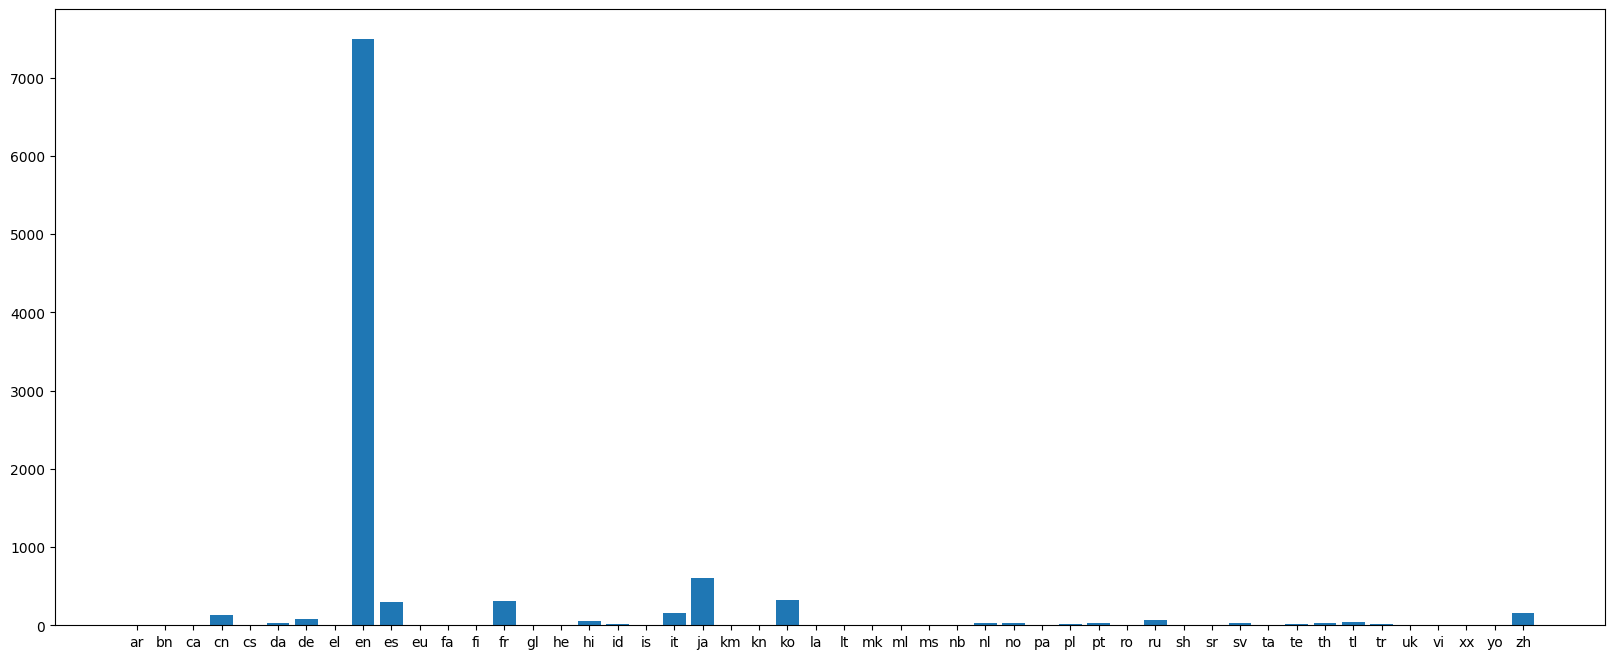

In [41]:
# Visualizing category distribution for original language
plt.figure(figsize=(20, 8))
plt.bar(ol_df.index, ol_df['Id'])

As can be seen, English 'en' has a considerable share compared to other languages. Therefore, we are going to limit this to two categories only, English and not_english

In [42]:
# method to transform OriginalLanguage
def replace_language(item):
    '''function to replace the original language by a binary form'''
    if item == 'en':
        return 1
    else:
        return 0

In [43]:
df['OriginalLanguage'] = df['OriginalLanguage'].apply(replace_language)

In [44]:
df['OriginalLanguage'].head()

0    1
1    1
2    1
3    1
4    0
Name: OriginalLanguage, dtype: int64

In [45]:
df.dtypes

Id                           int64
OriginalLanguage             int64
OriginalTitle               object
Overview                    object
Popularity                 float64
ReleaseDate         datetime64[ns]
Title                       object
VoteAverage                float64
VoteCount                    int64
Budget                       int64
TagLine                     object
RunTime                      int64
Revenue                      int64
Genres                      object
North America                int64
Europe                       int64
Asia                         int64
Oceania                      int64
South America                int64
Africa                       int64
dtype: object

In [46]:
df.columns

Index(['Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Genres', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa'],
      dtype='object')

Note: In this second section, we discovered the data separating numerical from categoricals, then applied different strategies to transform the categoricals from plain text to numerical values; we had to use some assumptions to reduce the cardinality in some of the categorical data.

### 3. Inspect and impute nulls

In [47]:
#checking number of nulls by column
df.isna().sum()

Id                     0
OriginalLanguage       0
OriginalTitle          0
Overview              51
Popularity             0
ReleaseDate           21
Title                  0
VoteAverage            0
VoteCount              0
Budget                 0
TagLine             2413
RunTime                0
Revenue                0
Genres                 0
North America          0
Europe                 0
Asia                   0
Oceania                0
South America          0
Africa                 0
dtype: int64

In [48]:
#Impute nulls in Overview and TagLinere, placing by empty string

df['Overview'].fillna('', inplace=True)
df['TagLine'].fillna('', inplace=True)

In [49]:
# Remove nulls in ReleaseDate, there are just 21 records and there is not a reasonable way to impute the date of release

df.dropna(subset=['ReleaseDate'], inplace=True)
df.shape


(9979, 20)

In [50]:
#checking number of nulls by column
df.isna().sum()

Id                  0
OriginalLanguage    0
OriginalTitle       0
Overview            0
Popularity          0
ReleaseDate         0
Title               0
VoteAverage         0
VoteCount           0
Budget              0
TagLine             0
RunTime             0
Revenue             0
Genres              0
North America       0
Europe              0
Asia                0
Oceania             0
South America       0
Africa              0
dtype: int64

Note: we removed the nulls by replacing them with empty strings in the text columns and removing the whole rows in ReleaseDate. This last one, considering there were just a few nulls (21) and no reasonable way to impute the values.

### 4. Inspect and correct duplicated rows

In [51]:
df.duplicated().sum()

0

Note: There were not duplicated rows

### 5. create new cleaned dataset (movies_cleaned.csv)

In [52]:
# store final clearned dataset in CSV

df.to_csv('movies_cleaned.csv', index=False)

 ##  Outliers Identification

In [53]:
#reading the clean data
data = pd.read_csv('movies_cleaned.csv', lineterminator='\n', index_col='Id')
data.head()

,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,TagLine,RunTime,Revenue,Genres,North America,Europe,Asia,Oceania,South America,Africa\r
Id,,,,,,,,,,,,,,,,,,,
299054,1,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,100000000,They'll die when they're dead.,103,30000000,"Action, Adventure, Thriller",0,0,0,0,0,0
926393,1,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027,70000000,Justice knows no borders.,109,176933602,"Action, Thriller, Crime",1,0,0,0,0,0
1034062,1,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27,0,Neon lights... Suits with shoulder pads... Jum...,80,0,"Animation, Action, Fantasy",1,0,0,0,0,0
575264,1,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799,291000000,We all share the same fate.,164,567148955,"Action, Thriller",1,0,0,0,0,0
1151534,0,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686,0,Attempting to survive in the middle of nowhere...,109,0,"Thriller, Drama",0,0,0,0,0,0


In [54]:
# Indentifing the numercial columns in the clean dataset
data.select_dtypes(include=['int', 'float']).columns

Index(['OriginalLanguage', 'Popularity', 'VoteAverage', 'VoteCount', 'Budget',
       'RunTime', 'Revenue', 'North America', 'Europe', 'Asia', 'Oceania',
       'South America', 'Africa\r'],
      dtype='object')

In [55]:
# Filtering out the discrete numerical columns (those are categorical that were enconded in previous steps)
numerical_columns = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget','RunTime', 'Revenue']
numerical_df = data[numerical_columns]

In [56]:
numerical_df.describe()

,Popularity,VoteAverage,VoteCount,Budget,RunTime,Revenue
count,9979.000000,9979.000000,9979.000000,9.979000e+03,9979.000000,9.979000e+03
mean,34.276587,6.380619,1623.563082,2.048210e+07,101.937268,6.238473e+07
std,84.418679,1.352348,2962.822512,3.881605e+07,27.358958,1.563777e+08
min,13.049000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,15.589500,6.000000,170.000000,0.000000e+00,91.000000,0.000000e+00
50%,20.099000,6.600000,564.000000,2.200000e+06,101.000000,3.775000e+06
75%,30.352500,7.100000,1668.000000,2.500000e+07,115.000000,5.461456e+07
max,3741.062000,10.000000,34628.000000,4.600000e+08,400.000000,2.923706e+09


### Boxplots

In [57]:
# Function to create boxplot to see percetiles and outliers presence

def create_box_plot(column, title, r1, r2):
    q3 = np.percentile(column, 75)
    q1 = np.percentile(column, 25)
    IQR = q3 - q1
    upper_fence = q3 + IQR * 1.5
    lower_fence = q1 - IQR * 1.5

    fig = plt.figure(1, figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.set_title(title + " Boxplot")
    
    r1 = min(r1, lower_fence)
    r2 = max(r2, upper_fence)

    ax.boxplot(column , vert=False, manage_ticks=True)
    ax.set_xlabel('values')
    ax.set_yticks([1])
    ax.set_yticklabels([title])

    quantiles = np.quantile(column , np.array([0.00, 0.25, 0.50, 0.75]))
    quantiles = np.append(quantiles, upper_fence)
    quantiles = np.insert(quantiles, 0, lower_fence)
    ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
              color='b', ls=':', lw=0.5, zorder=0)
    ax.set_ylim(0.5, 1.5)
    ax.set_xticks(quantiles)
    plt.xlim(r1, r2)
    ax.tick_params(axis='x', labelsize=8)
    plt.show()

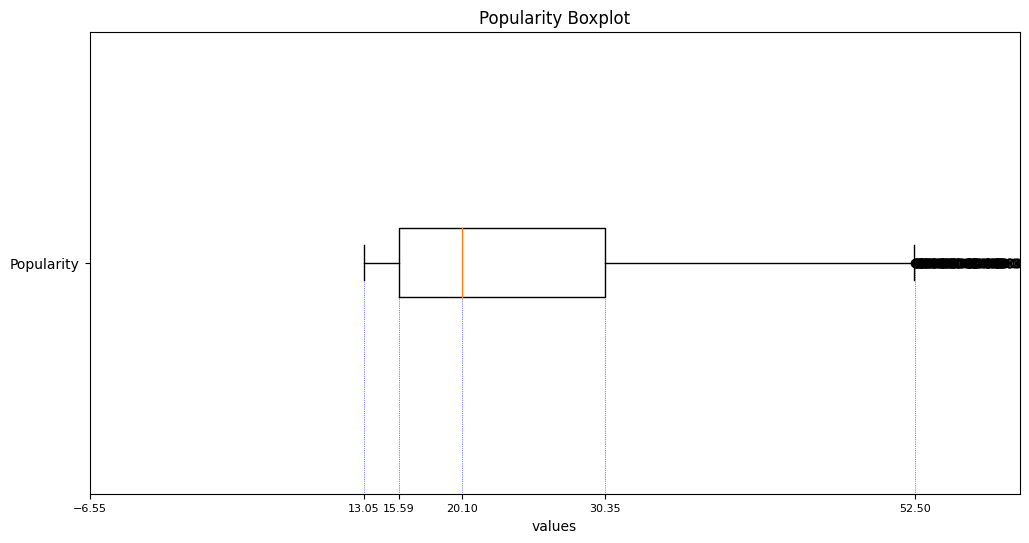

In [58]:
# Popularity Boxplot
create_box_plot(data['Popularity'], 'Popularity', 0, 60)

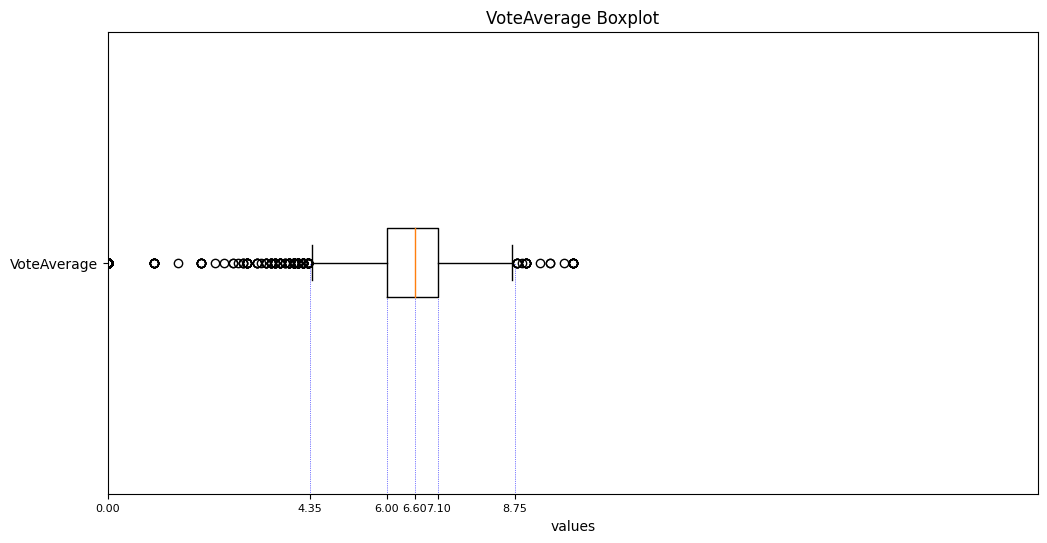

In [59]:
# VoteAverage Boxplot
create_box_plot(data['VoteAverage'], 'VoteAverage', 0, 20)

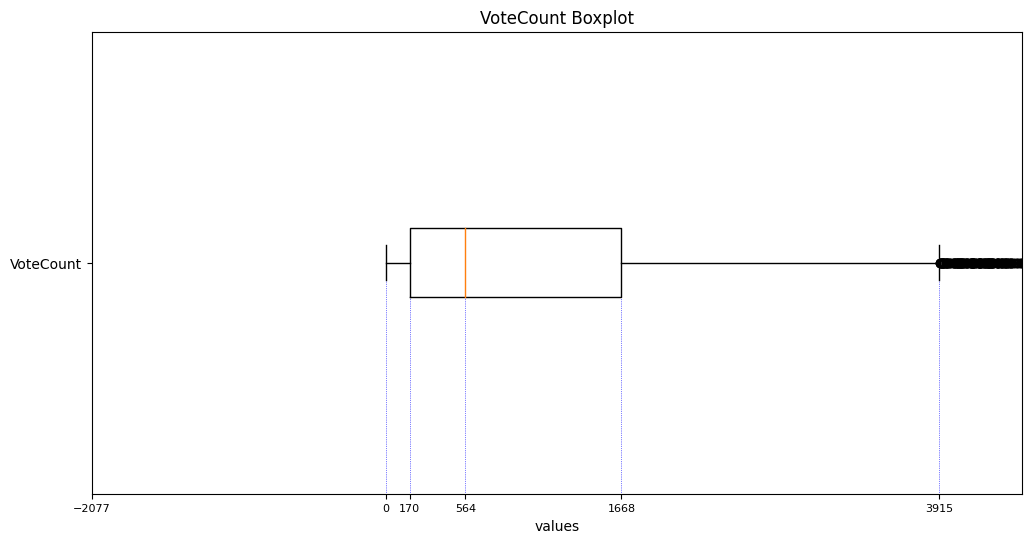

In [60]:
# VoteCount Boxplot
create_box_plot(data['VoteCount'], 'VoteCount', 0, 4500)

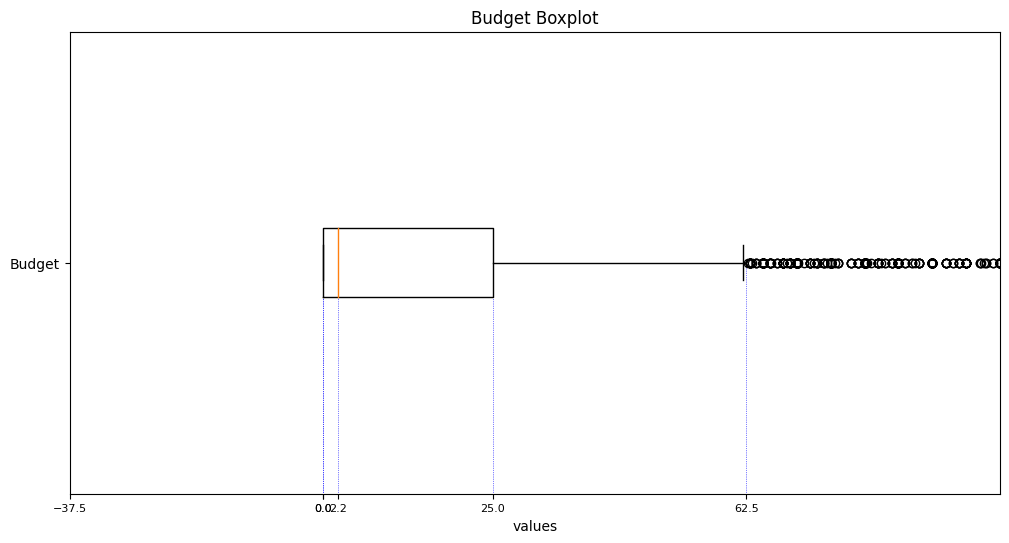

In [61]:
# Scaled Budget Boxplot
create_box_plot((data['Budget']) / 1000000, 'Budget', 0, 100)

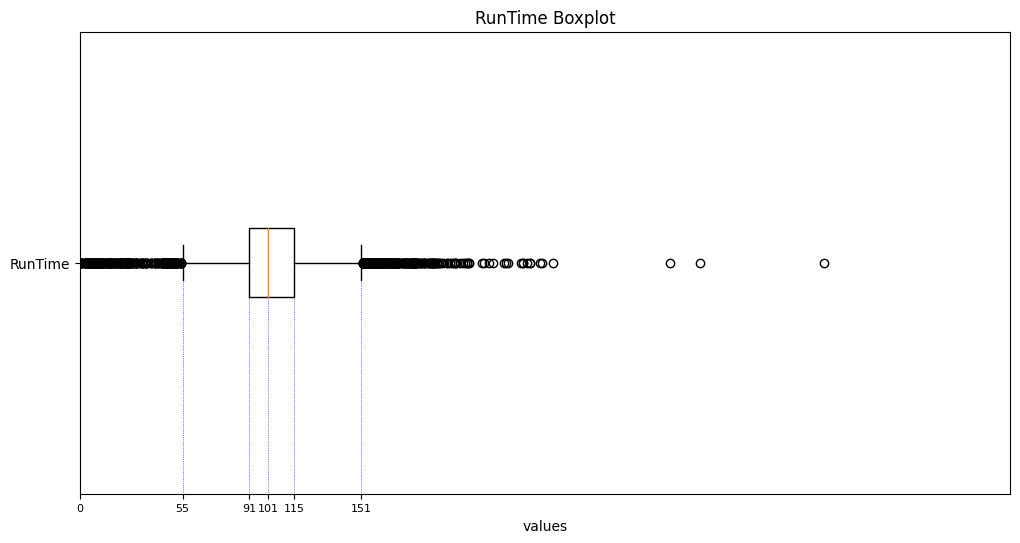

In [62]:
# RunTime Boxplot
create_box_plot(data['RunTime'], 'RunTime', 0, 500)

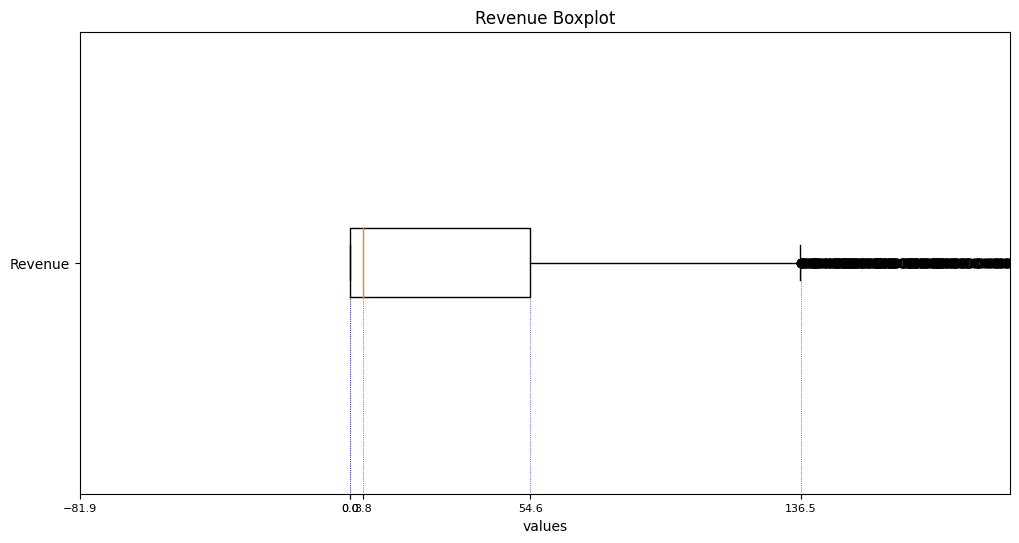

In [63]:
# Scaled Revenue Boxplot
create_box_plot((data['Revenue'] / 1000000), 'Revenue', 0, 200)

Notes:

The function "create_box_plot" was created to inspect the outliers in the columns visually:

1. The function accepts three arguments; "column" which is the data for the boxplot, "title" which impacts the title and label we want to add to the boxplot. And (r1,r2), which is the range of data we want to plot.
2. It calculates the percentiles q3, q1, and the IQR to compute the upper and lower fences to be included in the boxplot.
3. The quantiles  [0, 25, 50, 75] are calculated and stored in an array called "quantiles". The array is modified with the lower fence at position 0 and the upper fence at the last position.
4. The quantiles array is passed to the method, .vlines which handles the vertical lines
5. The quantiles array is also passed to the .set_xticks to see the numbers in the x-axis in the boxplot
6. Finally, the range in X to plot is established using the method .xlim

The plots show:

1. Popularity: Shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 25% of the data fall below 15.59, 50% of the data fall below 20.1, 75% of the data fall below 30.33. The upper extreme is at 52, and the lower extreme is at 13.05.

2. VoteAverage: This shows a symmetric distribution and the presence of outliers in the upper and lower levels. 25% of the data fall below 6.00, 50% of the data fall below 6.60, 75% of the data fall below 7.10. The upper extreme is at 8.75, and the lower extreme is at 4.35.

3. VoteCount: Shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 25% of the data fall below 170, 50% of the data fall below 564, and 75% of the data fall below 1668. The upper extreme is at 3915, and the lower extreme is at 0.

4. Budget: The budget was scaled down to facilitate plotting. It shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 50% of the data fall below 2.2M, and 75% of the data fall below 25M. The upper extreme is at 62.5M, and the lower extreme is at 0.

5. RunTime: Shows a symmetric distribution and the presence of outliers in the upper and lower levels. 25% of the data fall below 91 min, 50% of the data fall below 101 min, and 75% of the data fall below 115 min. The upper extreme is at 151 min, and the lower extreme is at 55 min.

6. Revenue: Revenue was scaled down to facilitate plotting. It shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 50% of the data fall below 8.8 M, and 75% of the data fall below 54.6 M. The upper extreme is at 136.5 M, and the lower extreme is at 0.




## Outliers Handling

### Method 1: Quantile-based Flooring and Capping

In [64]:
# Function to apply flooring and capping method for outlier handling

def apply_flooring_capping(data, floor, cap):
    floor_q = data.quantile(0.01)
    cap_q = data.quantile(0.99)
    result = data.copy()
    result = np.where(result < floor_q, floor_q, result)
    result = np.where(result > cap_q, cap_q, result)
    return result
    

In [65]:
# Function to plot two boxplot
def create_boxplots(arr1, arr2, r1, r2, label1, label2):
    ax = sns.boxplot(data=[arr1, arr2], orient='h')
    plt.xlim(r1, r2)
    ax.set_yticklabels([label1, label2]) 

In [66]:
# Applying quantile-based flooring and capping to Popularity

popularity_fc = apply_flooring_capping(data['Popularity'], 0.01, 0.99)

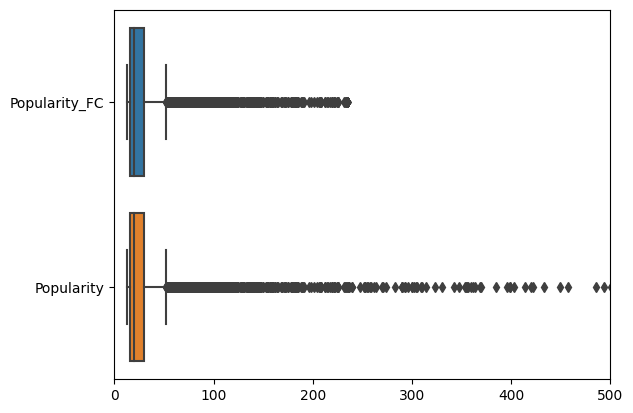

In [67]:
# Boxplots to compate Popularity with and without quantile-based flooring and capping
create_boxplots(popularity_fc, data['Popularity'], 0, 500, 'Popularity_FC', 'Popularity')

In [68]:
# Applying quantile-based flooring and capping to VoteAverage

vote_average_fc = apply_flooring_capping(data['VoteAverage'], 0.01, 0.99)

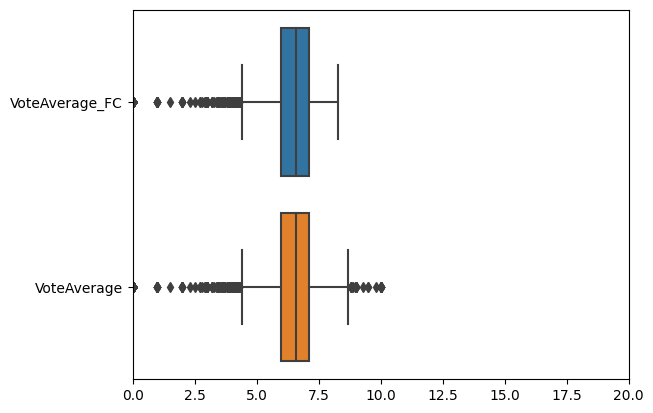

In [69]:
# Boxplots to compate VoteAverage with and without quantile-based flooring and capping
create_boxplots(vote_average_fc, data['VoteAverage'], 0, 20, 'VoteAverage_FC', 'VoteAverage')

In [70]:
# Applying quantile-based flooring and capping to VoteCount

vote_count_fc = apply_flooring_capping(data['VoteCount'], 0.01, 0.99)

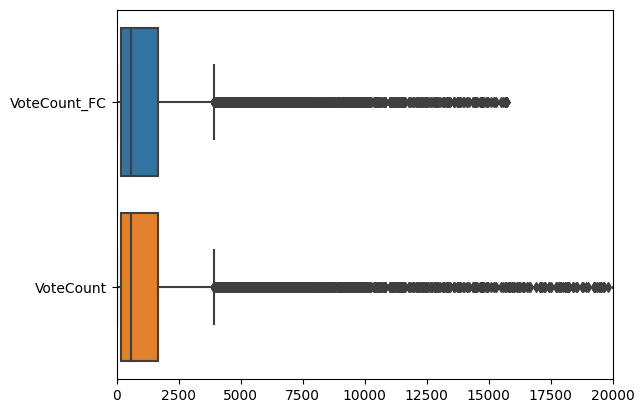

In [71]:
# Boxplots to compate VoteCount with and without quantile-based flooring and capping
create_boxplots(vote_count_fc, data['VoteCount'], 0, 20000, 'VoteCount_FC', 'VoteCount')

In [72]:
# Applying quantile-based flooring and capping to Budget

budget_fc = apply_flooring_capping(data['Budget'], 0.01, 0.99)

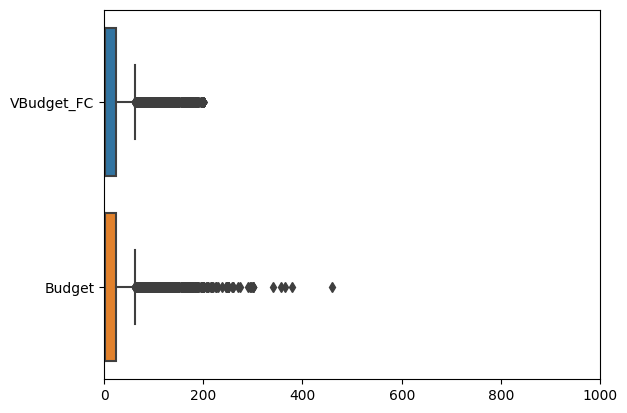

In [73]:
# Boxplots to compate VoteCount with and without quantile-based flooring and capping
create_boxplots(budget_fc / 1000000, data['Budget'] / 1000000, 0, 1000, 'VBudget_FC', 'Budget')

In [74]:
# Applying quantile-based flooring and capping to RunTime

runtime_fc = apply_flooring_capping(data['RunTime'], 0.01, 0.99)

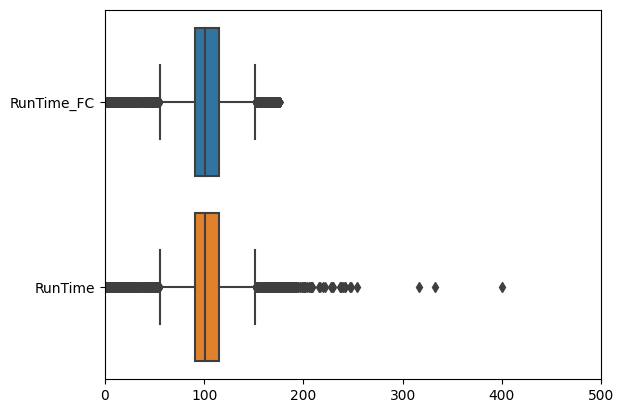

In [75]:
# Boxplots to compate RunTime with and without quantile-based flooring and capping
create_boxplots(runtime_fc, data['RunTime'], 0, 500, 'RunTime_FC', 'RunTime')

In [76]:
# Applying quantile-based flooring and capping to Revenue

revenue_fc = apply_flooring_capping(data['Revenue'], 0.01, 0.99)

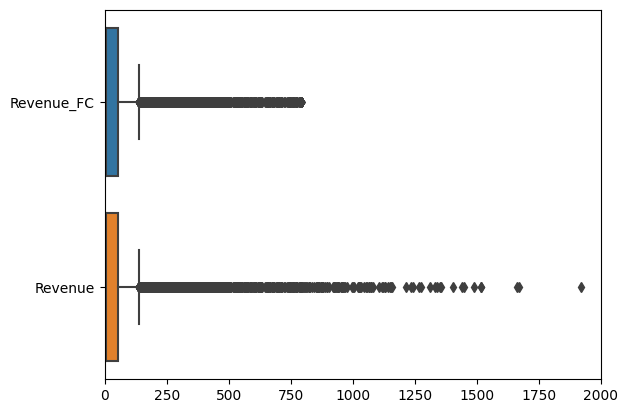

In [77]:
# Boxplots to compate RunTime with and without quantile-based flooring and capping
create_boxplots(revenue_fc / 1000000, data['Revenue'] / 1000000, 0, 2000, 'Revenue_FC', 'Revenue')

### Method 2: Trimming 

In [78]:
numerical_columns = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget','RunTime', 'Revenue']

In [79]:
# method to return a copy of a data frame after trimming the numerical valiables
def get_trimmed_data(data, numerical_columns):
    result = data.copy()
    for col in numerical_columns:
        upper_q = np.quantile(data[col], 0.75)
        lower_q = np.quantile(data[col], 0.25)
        IQR = upper_q - lower_q
        upper_whisker = upper_q + (1.5 * IQR)
        lower_whisker = lower_q - (1.5 * IQR)
        indexes = result[(result[col] > upper_whisker) | (result[col] < lower_whisker)].index
        print(f'Droping {indexes.shape[0]} indexes for {col}')
        result.drop(indexes, inplace=True)
        print(f'Data final shape {result.shape}')
    return result  
    

In [80]:
# getting trimmed new data
trimmed_data = get_trimmed_data(data, numerical_columns)

Droping 1035 indexes for Popularity
Data final shape (8944, 19)
Droping 421 indexes for VoteAverage
Data final shape (8523, 19)
Droping 662 indexes for VoteCount
Data final shape (7861, 19)
Droping 389 indexes for Budget
Data final shape (7472, 19)
Droping 420 indexes for RunTime
Data final shape (7052, 19)
Droping 258 indexes for Revenue
Data final shape (6794, 19)


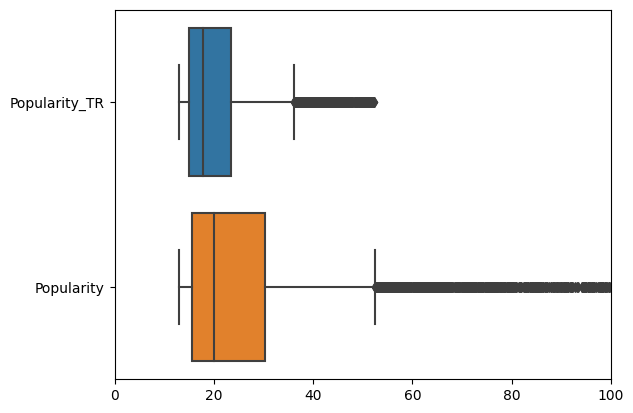

In [81]:
# Boxplots to compare trimmed and no-trimmed Popularity
create_boxplots(trimmed_data['Popularity'], data['Popularity'], 0, 100, 'Popularity_TR', 'Popularity')

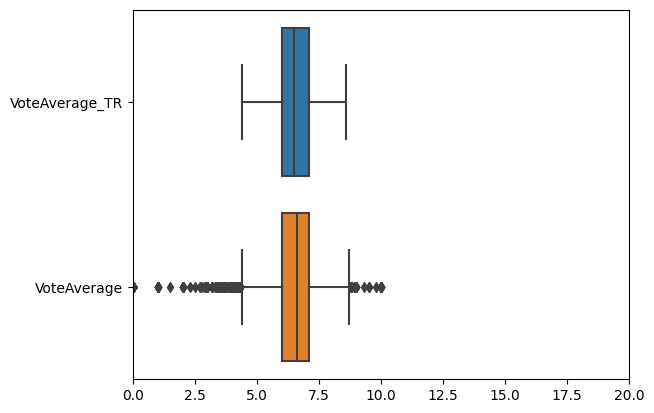

In [82]:
# Boxplots to compare trimmed and no-trimmed 'VoteAverage'
create_boxplots(trimmed_data['VoteAverage'], data['VoteAverage'], 0, 20, 'VoteAverage_TR', 'VoteAverage')

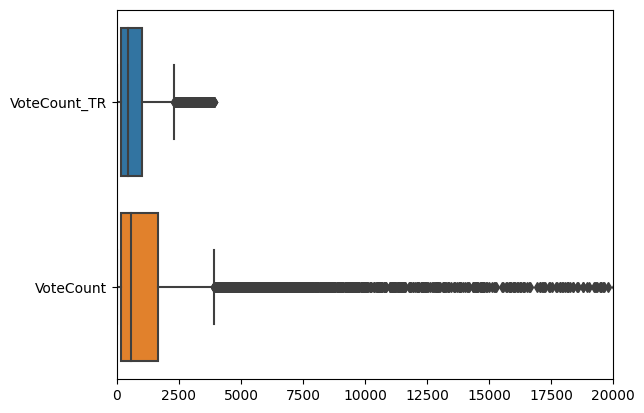

In [83]:
# Boxplots to compare trimmed and no-trimmed VoteCount
create_boxplots(trimmed_data['VoteCount'], data['VoteCount'], 0, 20000, 'VoteCount_TR', 'VoteCount')

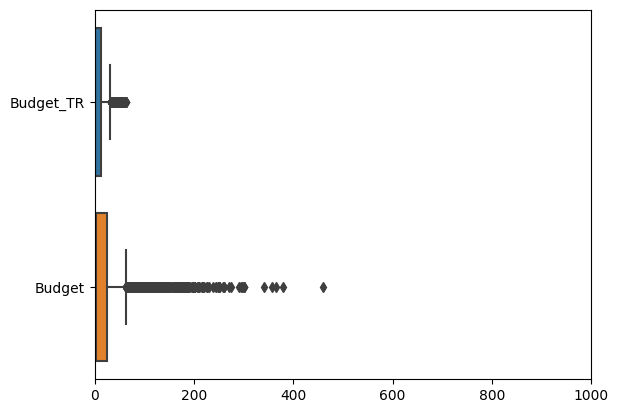

In [84]:
# Boxplots to compare trimmed and no-trimmed Budget
create_boxplots(trimmed_data['Budget'] / 1000000, data['Budget'] / 1000000, 0, 1000, 'Budget_TR', 'Budget')

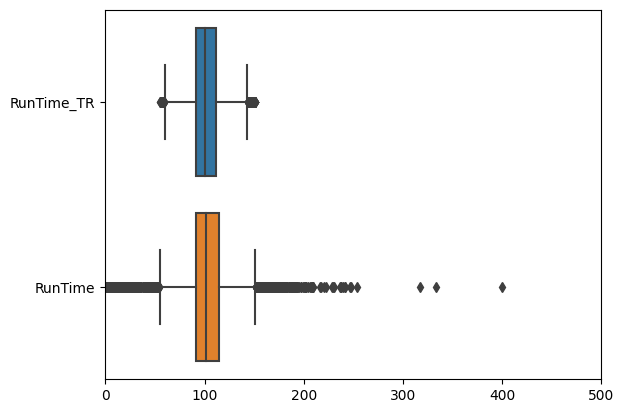

In [85]:
# Boxplots to compare trimmed and no-trimmed RunTime
create_boxplots(trimmed_data['RunTime'], data['RunTime'], 0, 500, 'RunTime_TR', 'RunTime')

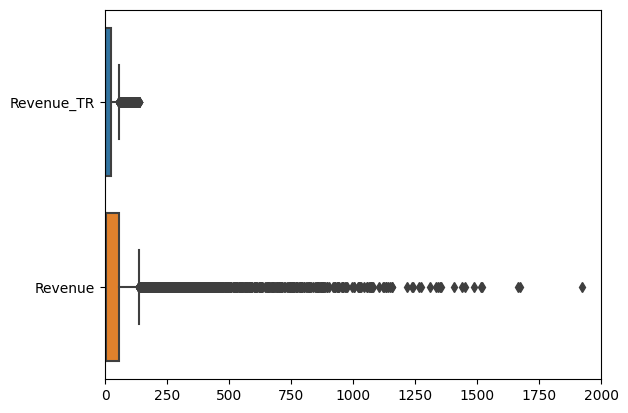

In [86]:
# Boxplots to compare trimmed and no-trimmed Revenue
create_boxplots(trimmed_data['Revenue'] / 1000000, data['Revenue']/1000000, 0, 2000, 'Revenue_TR', 'Revenue')

### Method 3: Log Transformation

In [87]:
# Function to apply log tranformation to data, returns a copy with transformed columns
def get_log_transformed_data(data, numerical_columns):
    result = data.copy()
    for col in numerical_columns:
        result[col] = result[col].map(lambda x: np.log(x) if x > 0 else 0)
    return result
    

In [88]:
# create graph to compare boxplots
def pair_boxplots(arr1, arr2, label1, label2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].boxplot(arr1, vert=False)
    axes[0].set_title(f'Boxplot {label1}')
    axes[1].boxplot(arr2, vert=False)
    axes[1].set_title(f'Boxplot {label2}')
    plt.show()
    
# create graph to compare histograms
def pair_histograms(arr1, arr2, label1, label2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(arr1, bins=20)
    axes[0].set_title(f'Histogram {label1}')
    axes[1].hist(arr2, bins=20)
    axes[1].set_title(f'Histogram {label2}')
    plt.show()


In [89]:
# Understanding skewness correction for Popularity
log_transformed_data = get_log_transformed_data(data, numerical_columns)
skewness_td = log_transformed_data['Popularity'].skew().round(2)
skewness_d = data['Popularity'].skew().round(2)
print(f'Skewness transformed data {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data 2.13
Skewness data: 20.15


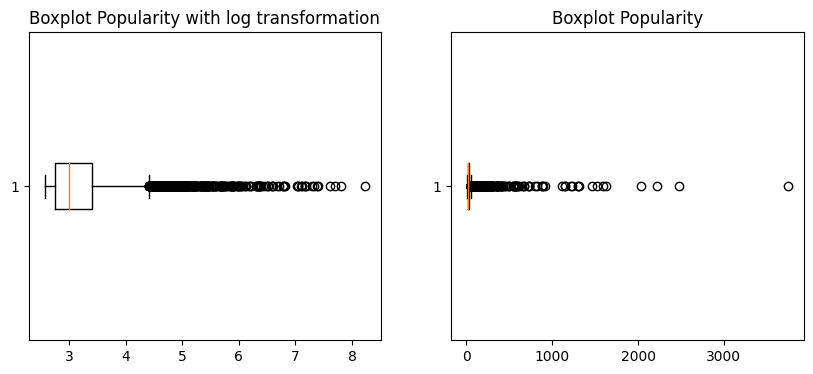

In [90]:
# boxplots for Popularity with and without log transformation
pair_boxplots(log_transformed_data['Popularity'], data['Popularity'], 'Popularity with log transformation', 'Popularity')

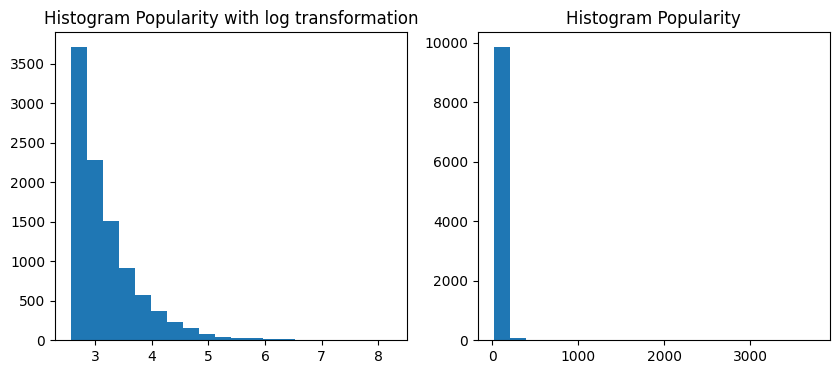

In [91]:
# histograms for Popularity with and without log transformation
pair_histograms(log_transformed_data['Popularity'], data['Popularity'], 'Popularity with log transformation', 'Popularity')

In [92]:
# Understanding skewness correction for VoteAverage
skewness_td = log_transformed_data['VoteAverage'].skew().round(2)
skewness_d = data['VoteAverage'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -4.37
Skewness data: -2.59


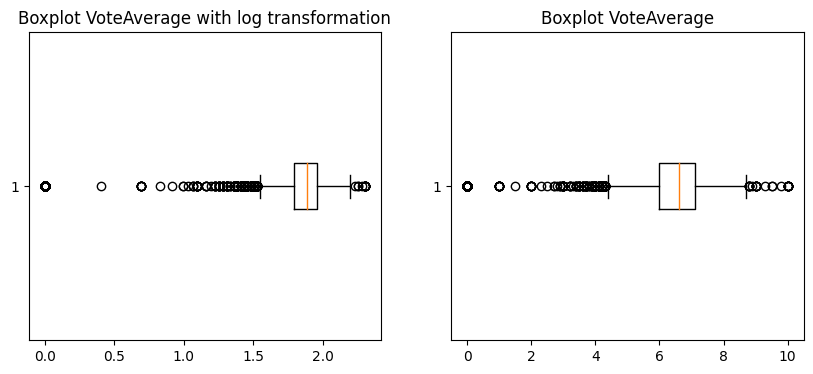

In [93]:
# boxplots for VoteAverage with and without log transformation
pair_boxplots(log_transformed_data['VoteAverage'], data['VoteAverage'], 'VoteAverage with log transformation', 'VoteAverage')

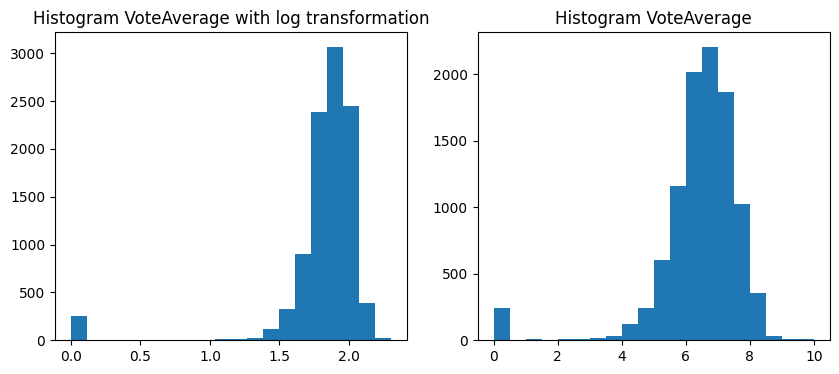

In [94]:
# histograms for VoteAverage with and without log transformation
pair_histograms(log_transformed_data['VoteAverage'], data['VoteAverage'], 'VoteAverage with log transformation', 'VoteAverage')

In [95]:
# Understanding skewness correction for VoteCount
skewness_td = log_transformed_data['VoteCount'].skew().round(2)
skewness_d = data['VoteCount'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.98
Skewness data: 4.04


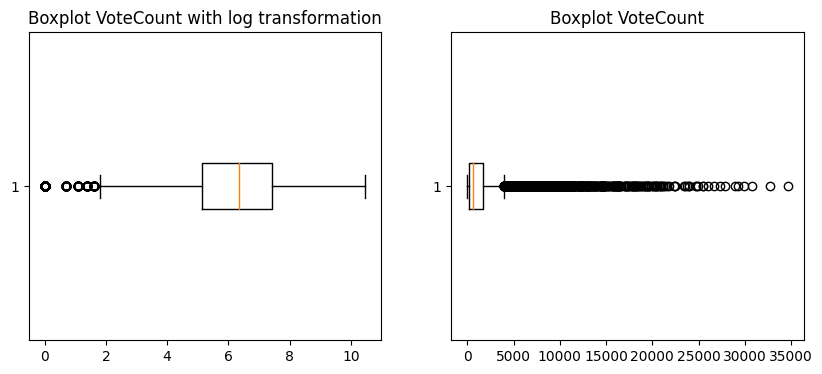

In [96]:
# boxplots for VoteCount with and without log transformation
pair_boxplots(log_transformed_data['VoteCount'], data['VoteCount'], 'VoteCount with log transformation', 'VoteCount')

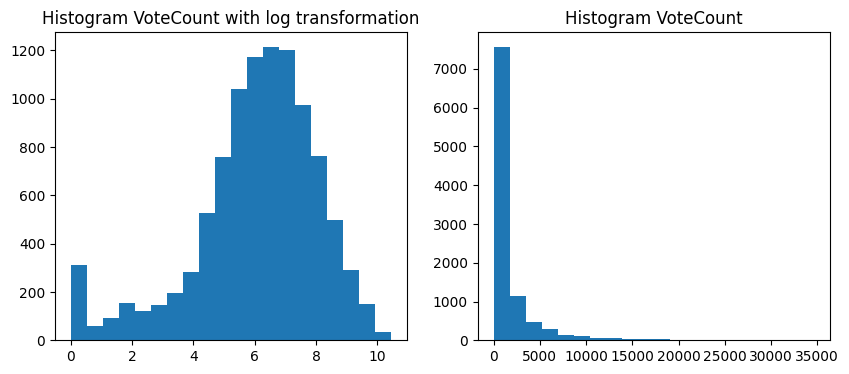

In [97]:
# histograms for VoteCount with and without log transformation
pair_histograms(log_transformed_data['VoteCount'], data['VoteCount'], 'VoteCount with log transformation', 'VoteCount')

In [98]:
#Understanding skewness correction for Budget
skewness_td = log_transformed_data['Budget'].skew().round(2)
skewness_d = data['Budget'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.16
Skewness data: 3.24


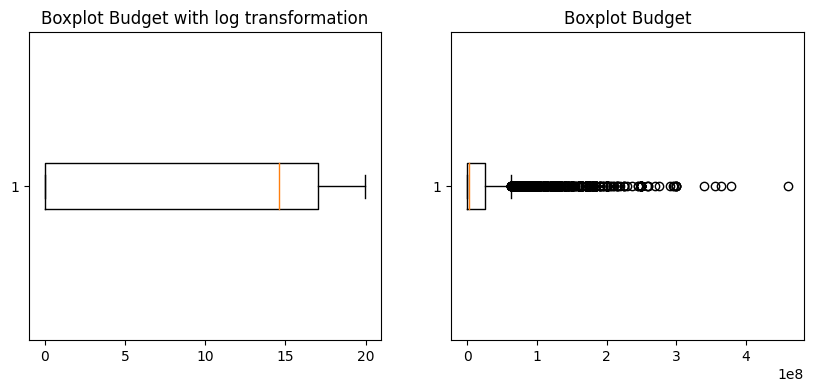

In [99]:
# boxplots for Budget with and without log transformation
pair_boxplots(log_transformed_data['Budget'], data['Budget'], 'Budget with log transformation', 'Budget')

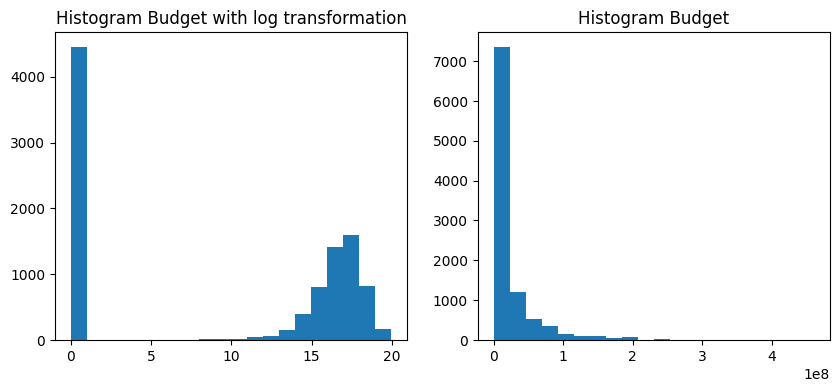

In [100]:
# histograms for Popularity with and without log transformation
pair_histograms(log_transformed_data['Budget'], data['Budget'], 'Budget with log transformation', 'Budget')

In [101]:
# Understanding skewness correction for RunTime
skewness_td = log_transformed_data['RunTime'].skew().round(2)
skewness_d = data['RunTime'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -5.55
Skewness data: -0.35


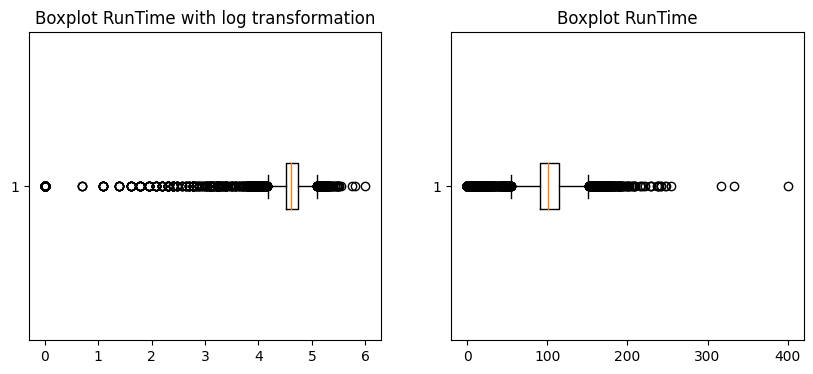

In [102]:
# boxplots for RunTime with and without log transformation
pair_boxplots(log_transformed_data['RunTime'], data['RunTime'], 'RunTime with log transformation', 'RunTime')

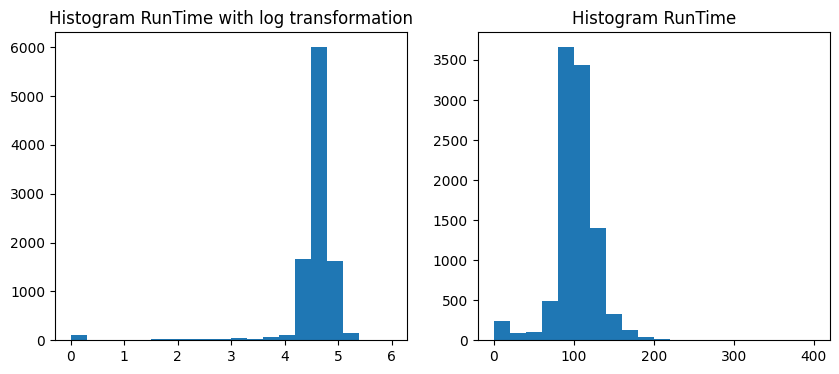

In [103]:
# histograms for RunTime with and without log transformation
pair_histograms(log_transformed_data['RunTime'], data['RunTime'], 'RunTime with log transformation', 'RunTime')

In [104]:
# Understanding skewness correction for Revenue
skewness_td = log_transformed_data['Revenue'].skew().round(2)
skewness_d = data['Revenue'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.25
Skewness data: 5.89


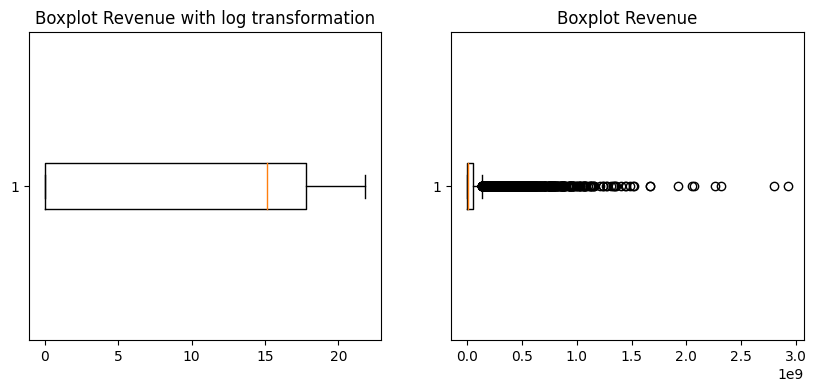

In [105]:
# boxplots for Revenue with and without log transformation
pair_boxplots(log_transformed_data['Revenue'], data['Revenue'], 'Revenue with log transformation', 'Revenue')

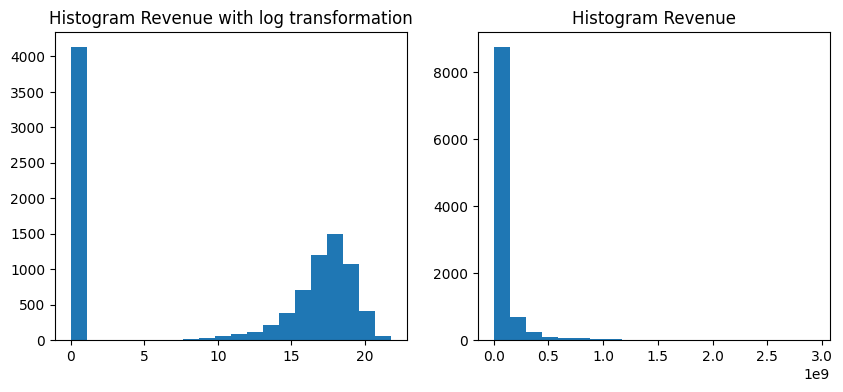

In [106]:
# histograms for Revenue with and without log transformation
pair_histograms(log_transformed_data['Revenue'], data['Revenue'], 'Revenue with log transformation', 'Revenue')

In [107]:
# applying Trimming to log transformed Popularity
logt_trimmed_data = get_trimmed_data(log_transformed_data, ['Popularity'])

Droping 482 indexes for Popularity
Data final shape (9497, 19)


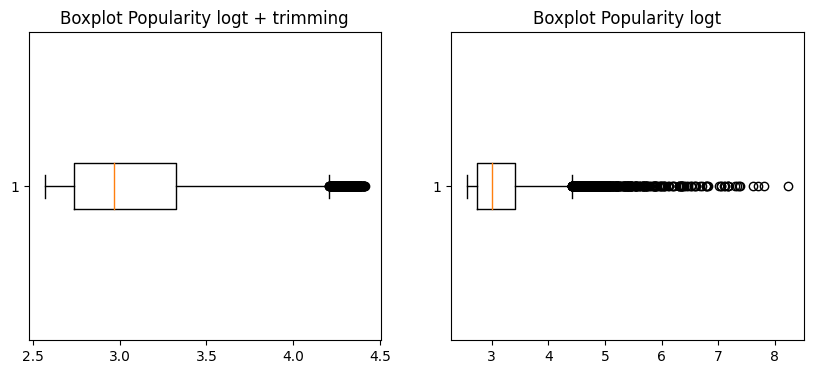

In [108]:
# final Popularity log transformation + trimming

pair_boxplots(logt_trimmed_data['Popularity'], log_transformed_data['Popularity'], 'Popularity logt + trimming', 'Popularity logt')

In [109]:
# final dataset without outliers

# 1 Trimming columns 'VoteAverage' and 'RunTime'
movies_data_trimmed = get_trimmed_data(data, ['VoteAverage', 'RunTime'])

# Log tranformation for 'Budget', 'Revenue', 'VoteCount' and 'Popularity'
movies_data_log_transform = get_log_transformed_data(movies_data_trimmed, ['Budget', 'Revenue', 'VoteCount', 'Popularity'])

# Apply trimming to the log tranformed 'Popularity'

movies_data = get_trimmed_data(movies_data_log_transform, ['Popularity'])


Droping 446 indexes for VoteAverage
Data final shape (9533, 19)
Droping 560 indexes for RunTime
Data final shape (8973, 19)
Droping 421 indexes for Popularity
Data final shape (8552, 19)


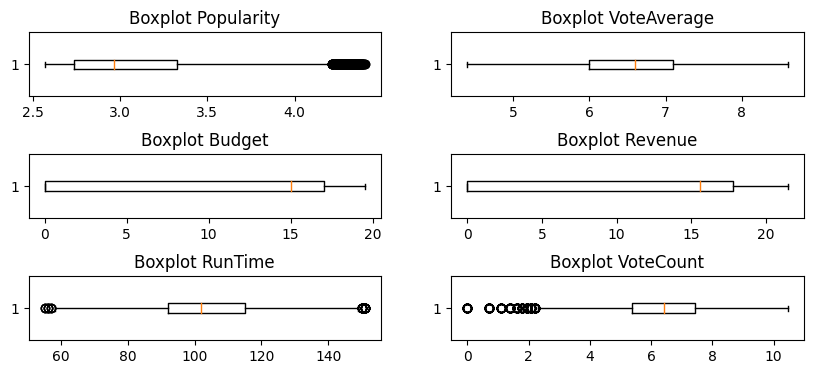

In [110]:
# boxplot to final confirm all distributions

fig, axes = plt.subplots(3, 2, figsize=(10, 4))
plt.subplots_adjust(hspace=0.9)
axes[0][0].boxplot(movies_data['Popularity'], vert=False)
axes[0][0].set_title('Boxplot Popularity')
axes[0][1].boxplot(movies_data['VoteAverage'], vert=False)
axes[0][1].set_title('Boxplot VoteAverage')
axes[1][0].boxplot(movies_data['Budget'], vert=False)
axes[1][0].set_title('Boxplot Budget')
axes[1][1].boxplot(movies_data['Revenue'], vert=False)
axes[1][1].set_title('Boxplot Revenue')
axes[2][0].boxplot(movies_data['RunTime'], vert=False)
axes[2][0].set_title('Boxplot RunTime')
axes[2][1].boxplot(movies_data['VoteCount'], vert=False)
axes[2][1].set_title('Boxplot VoteCount')
plt.show()


In [111]:
# storing the final dataset as movies_data.csv
movies_data.to_csv('movies_data.csv')

In [112]:
#reading the data without outliers
data = pd.read_csv('movies_data.csv', lineterminator='\n', index_col='Id')
data.head(2)

,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,TagLine,RunTime,Revenue,Genres,North America,Europe,Asia,Oceania,South America,Africa\r\r
Id,,,,,,,,,,,,,,,,,,,
27205,1,Inception,"Cobb, a skilled thief who commits corporate es...",4.401216,2010-07-15,Inception,8.4,10.452418,18.890684,Your mind is the scene of the crime.,148,20.531540,"Action, ScienceFiction, Adventure",1,1,0,0,0,0
497698,1,Black Widow,"Natasha Romanoff, also known as Black Widow, c...",4.399596,2021-07-07,Black Widow,7.3,9.142918,19.113828,Her world. Her secrets. Her legacy.,134,19.755027,"Action, Adventure, ScienceFiction",1,0,0,0,0,0


Notes:

Quantile-based Flooring and Capping:

- Overall, it showed an improvement in skewness. However, for all the columns, we still got a significant presence of outliers.

Trimming:

- This method is not an option as a unique method to fix outliers due to a significant data loss. After trimming, the number of rows was reduced from 9979 to just 6796 (32%). Additionally, in terms of improving outliers, although it reduced the skewness for some columns, it was more effective for 'VoteAverage' and 'RunTime' (both have the most symmetric distributions). The other columns still have a significant presence of outliers.
    
Log Transformation

- This method presents a small change for those columns that already have a symmetrical distribution, such as RunTime and VoteAverage. On the other hand, for those skewed distributions, this method allowed a more symmetrical one, as seen in Popularity, VoteCount, Budget, and Revenue.

- This transformation successfully removed outliers for 'Budget', 'Revenue' and 'VoteCount'. Additionally, it improved the distributions for Popularity and VoteCount.

Considering the results applying each of the methods for all the columns, we decided to remove the outliers as follows:

- 'VoteAverage' and 'RunTime' -> Trimming
- 'Budget', 'Revenue' and VoteCount-> Log Tranformation
- 'Popularity' -> Log Tranformation + Trimming

Using above strategy, we were able to remove ourliers and improve skewness for the columns.

Finally, we stored the dataset as movies_data.csv





In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8552 entries, 27205 to 54518
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OriginalLanguage  8552 non-null   int64  
 1   OriginalTitle     8552 non-null   object 
 2   Overview          8540 non-null   object 
 3   Popularity        8552 non-null   float64
 4   ReleaseDate       8552 non-null   object 
 5   Title             8552 non-null   object 
 6   VoteAverage       8552 non-null   float64
 7   VoteCount         8552 non-null   float64
 8   Budget            8552 non-null   float64
 9   TagLine           6771 non-null   object 
 10  RunTime           8552 non-null   int64  
 11  Revenue           8552 non-null   float64
 12  Genres            8544 non-null   object 
 13  North America     8552 non-null   int64  
 14  Europe            8552 non-null   int64  
 15  Asia              8552 non-null   int64  
 16  Oceania           8552 non-null   int64  


In [114]:
data['Overview']

Id
27205     Cobb, a skilled thief who commits corporate es...
497698    Natasha Romanoff, also known as Black Widow, c...
603       Set in the 22nd century, The Matrix tells the ...
843794    On an uninhabitable 22nd-century Earth, the ou...
446893    Queen Poppy and Branch make a surprising disco...
                                ...                        
2749      When Eastern European criminals Oleg and Emil ...
11128     Under the watchful eye of his mentor, Captain ...
484482    40-year-old Bertrand has been suffering from d...
453755    A man stranded in the Arctic is finally about ...
54518     Tells the story of Justin Bieber, the kid from...
Name: Overview, Length: 8552, dtype: object

In [115]:
data['TagLine']

Id
27205                  Your mind is the scene of the crime.
497698                  Her world. Her secrets. Her legacy.
603                              Welcome to the Real World.
843794                 AI Combat Warrior Will be Unleashed.
446893                               Happiest. Movie. Ever.
                                ...                        
2749                                 America Likes to Watch
11128     Their greatest challenge lies in rescuing one ...
484482                                                  NaN
453755                          Survival is the only option
54518        Find out what's possible if you never give up.
Name: TagLine, Length: 8552, dtype: object

In [116]:
df = data.copy()

In [117]:
df["Overview"] = df["Overview"].apply(lambda x: str(x).replace("\n", " ")
                                                              .replace("\t", " ")
                                                              .replace("\xa0", " ")
                                                              .replace("\r", " ")
                                                              .replace("[", "")
                                                              .replace("]", "")
                                                              .replace("\ufeff", "")
                                                              .replace("\u200b", "")
                                                              .replace("©", "")
                                                              .replace("|", "")
                                                              .replace("#", "")
                                                              .lower()
                                                              .strip())

df['Overview'] = df['Overview'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

df['Overview'] = df['Overview'].apply(lambda x: re.sub('[0-9]', '', x))

df["Overview"] = df["Overview"].apply(lambda x: re.sub(' +', ' ', x))


for i in range(len(df)):
    try:
        df.Overview[i] = emoji.replace_emoji(df.Overview[i], ' ')
    except:
        pass
    

stop_words = set(stopwords.words('english'))
stop_words.update(['https', 'http', 'com', 'www', 'https://', 
            'http://', 'com/', 'www/', 'width', 'device', 
            'initial', 'scale', 'height', 'px', 'px/', 'px',
            'ie', 'edge', 'chrome', 'firefox', 'safari', 'opera',
            'wi', 'x', 'com', 'website', 'builder', 'telephone', 'skype',
            'toolbar', 'button', 'link', 'image', 'icon', 'icon/',
            'parser', 'compatible', 'fcb', 'ea', 'cf',
            'drop', 'menu', 'de', 'ee', 'ab', 'bb', 'df', 'ff', 'fb', 'eb',
            'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
            'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
            'html', 'css', 'js', 'json', 'xml', 'json/', 'xml/', 'js/', 'json/',
            'char', 'set', 'utf', 'utf-', 'utf8', 'utf8/', 'utf8', 'utf8/',
            'text', 'minimum', 'maximum', 'length', 'required', 'optional',
            'index', 'nofollow', 'user', 'scalable', 'responsive', 'mobile'])
df['Overview'] = df['Overview'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


lemmatizer = WordNetLemmatizer()
df['Overview'] = df['Overview'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

for i in df.index:
    try:
        df.Overview[i] = contractions.fix(df.Overview[i])
    except:
        pass
    
words = set(nltk.corpus.words.words())
for i in df.index:
    df.Overview[i] = " ".join(w for w in nltk.wordpunct_tokenize(df.Overview[i]) \
         if w.lower() in words or not w.isalpha())

In [118]:
df['Overview']

Id
27205     skilled thief corporate espionage subconscious...
497698    also known black widow part ledger dangerous c...
603       century matrix tell story computer hacker join...
843794    uninhabitable earth outcome civil war hinge br...
446893    queen poppy branch make surprising discovery —...
                                ...                        
2749      eastern criminal come new york city pick share...
11128     watchful eye mentor captain mike probationary ...
484482    suffering depression last two year barely able...
453755    man arctic finally receive long rescue however...
54518     tell story canada hair smile voice chronicle u...
Name: Overview, Length: 8552, dtype: object

# Top Words

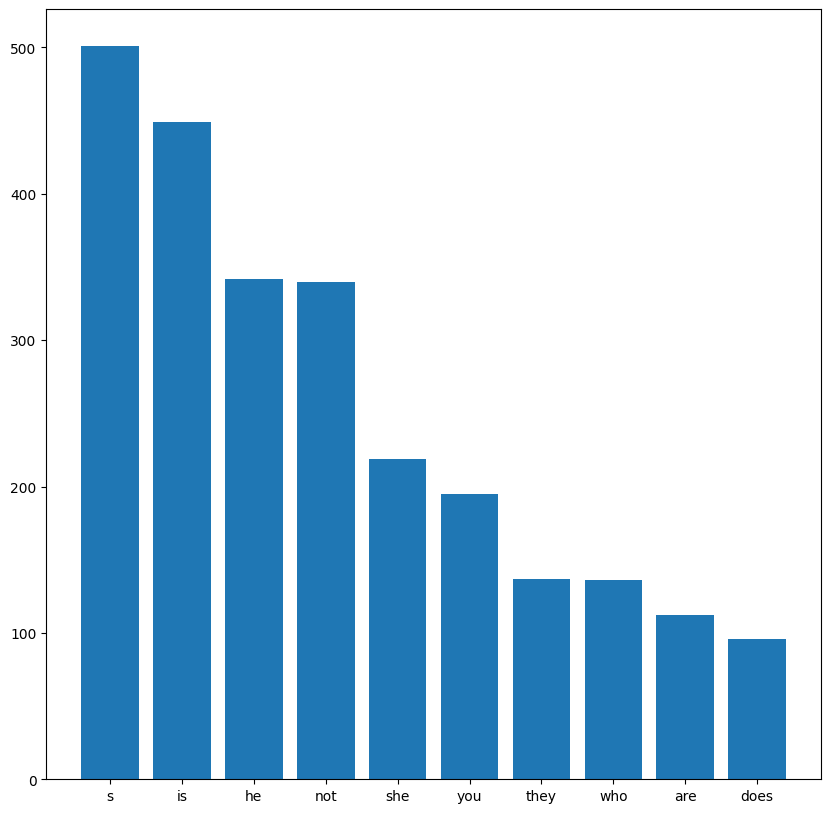

In [119]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.figure(figsize=(10,10))
    plt.bar(x,y)
    

plot_top_stopwords_barchart(df['Overview'])

# Top non stopwords

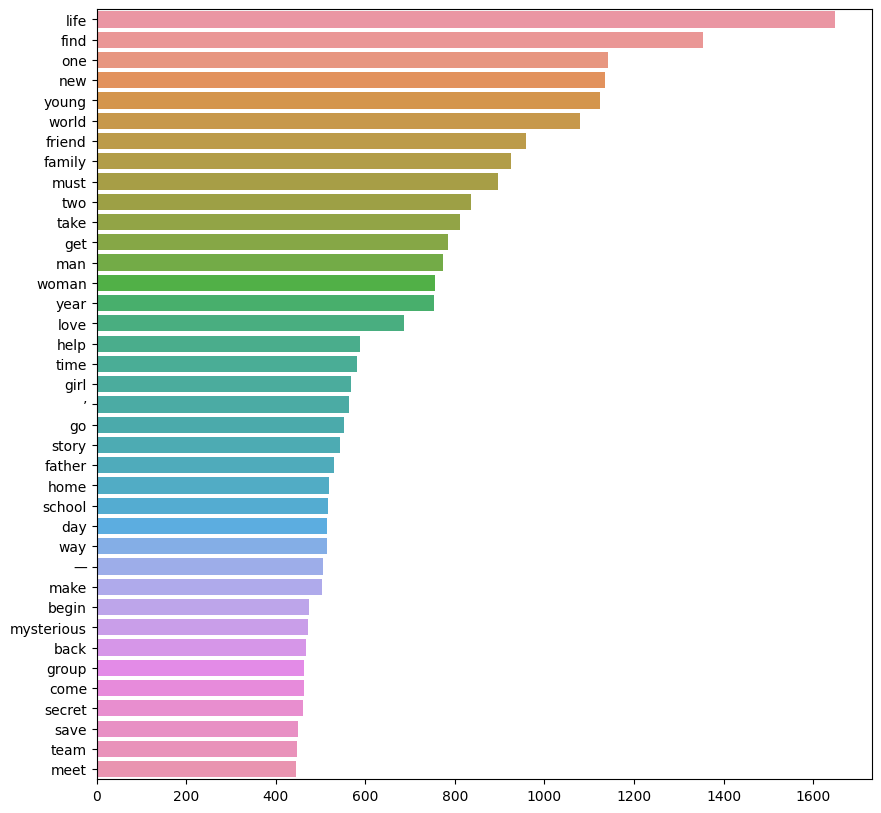

In [120]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

plot_top_non_stopwords_barchart(df['Overview'])

# Top n-grams

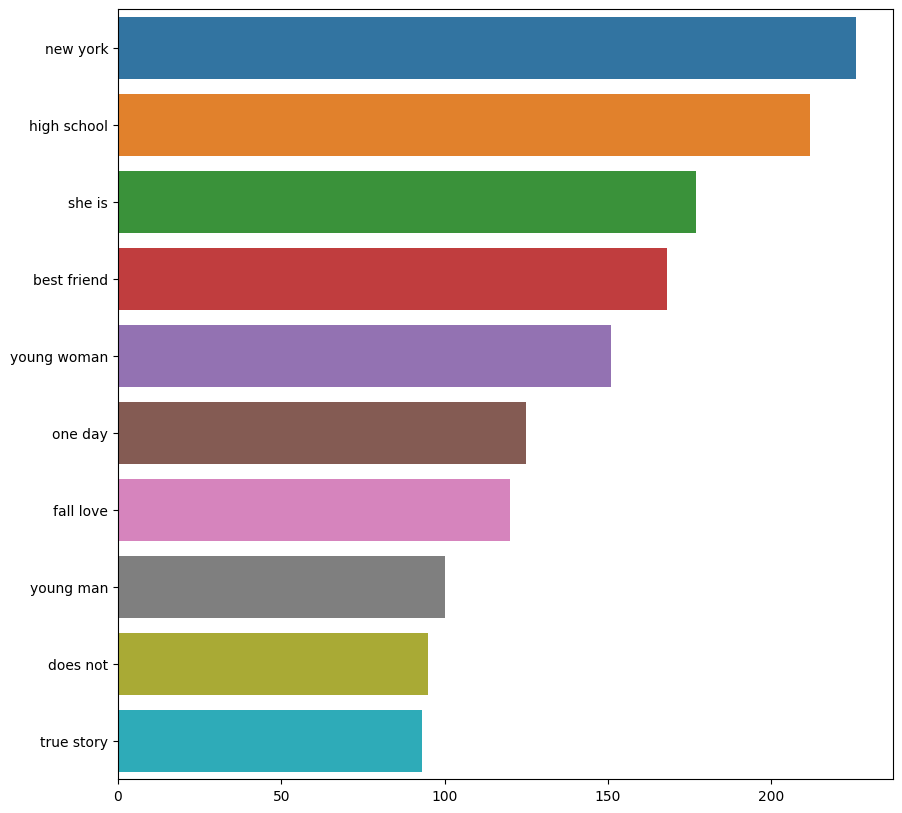

In [121]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(df['Overview'],2)

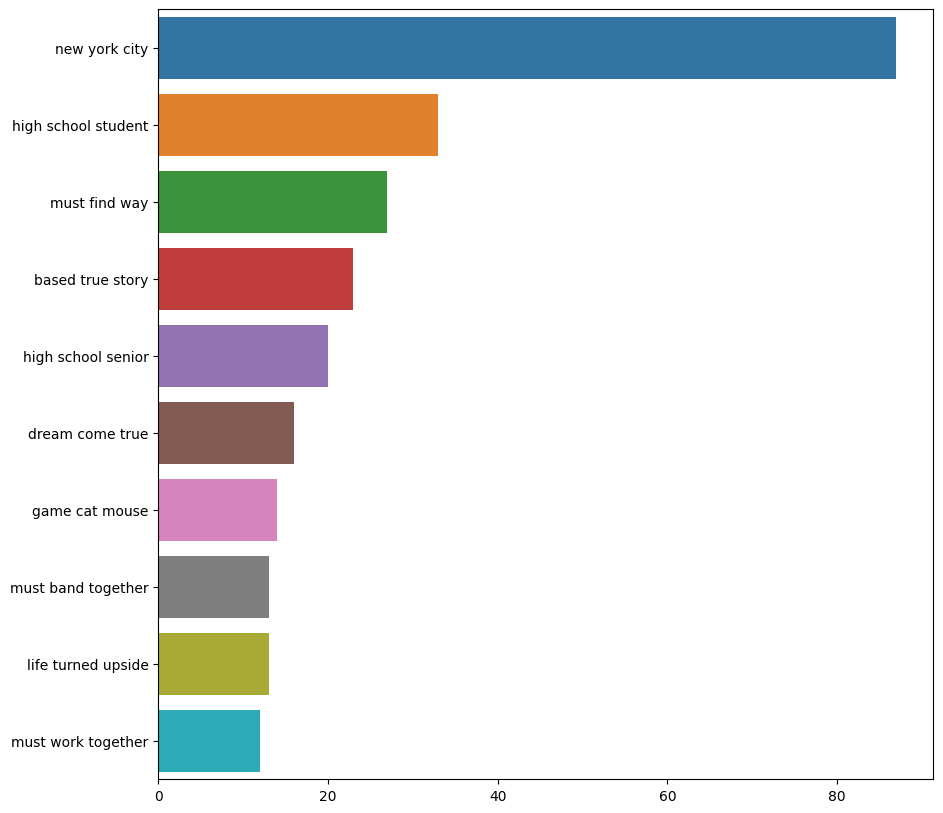

In [122]:
plot_top_ngrams_barchart(df['Overview'], 3)

# Topic modeling exploration with pyLDAvis

In [123]:
def get_lda_objects(text):   
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis


lda_model, bow_corpus, dic = get_lda_objects(df['Overview'])

lda_model.show_topics()

plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.019667  0.023376       1        1  17.868387
0      0.037783  0.036860       2        1  14.682309
8      0.031420  0.045535       3        1  11.308870
9      0.069465  0.044856       4        1  10.865074
2      0.006011  0.011353       5        1  10.638838
5     -0.019242  0.035448       6        1   8.670882
7      0.042491 -0.187539       7        1   7.600399
1      0.060383  0.115481       8        1   7.094224
6      0.011833 -0.137541       9        1   5.777523
4     -0.259811  0.012170      10        1   5.493493, topic_info=       Term        Freq        Total Category  logprob  loglift
84   friend  939.000000   939.000000  Default  30.0000  30.0000
550     son  471.000000   471.000000  Default  29.0000  29.0000
255  family  862.000000   862.000000  Default  28.0000  28.0000
217  father  532.000000   532.000000  Default  27.0000  27.0000
54    story  546.000000   546.000000  Default  26.0000  26.0000
..      ...         ...          ...      ...      ...      ...
391     car   29.738865   138.820420  Topic10  -5.8249   1.3609
352    girl   33.508222   622.366996  Topic10  -5.7056  -0.0201
507  school   32.060104   517.429401  Topic10  -5.7498   0.1203
418    time   31.849469   538.945830  Topic10  -5.7564   0.0730
9      life   30.949407  1562.732369  Topic10  -5.7850  -1.0202

[833 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5136      5  0.960986    abroad
3972      4  0.952635    abrupt
2608      3  0.944551   absence
721       2  0.552971  accident
721       3  0.291846  accident
...     ...       ...       ...
159       6  0.012644     young
159       7  0.121924     young
159       8  0.099345     young
159       9  0.043351     young
159      10  0.022579     young

[2086 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 9, 10, 3, 6, 8, 2, 7, 5])

# Word Cloud

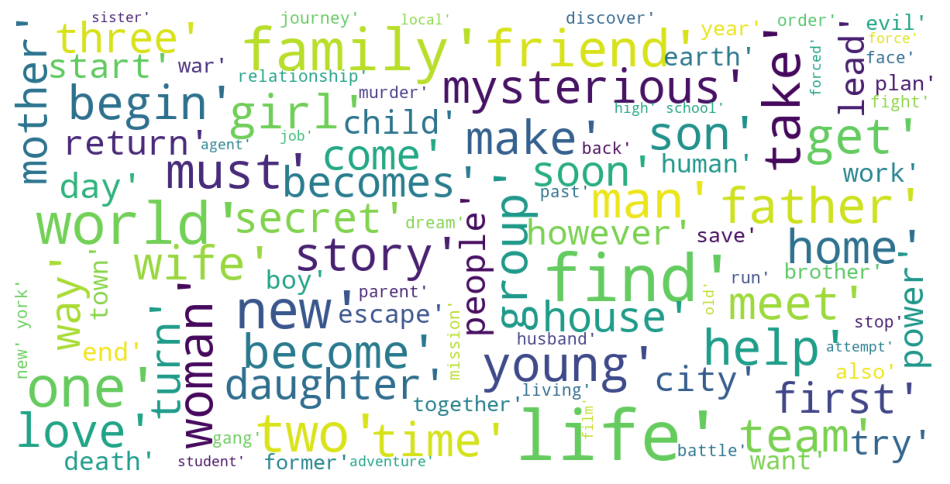

In [124]:
def plot_wordcloud(text):
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()
    
plot_wordcloud(df["Overview"])

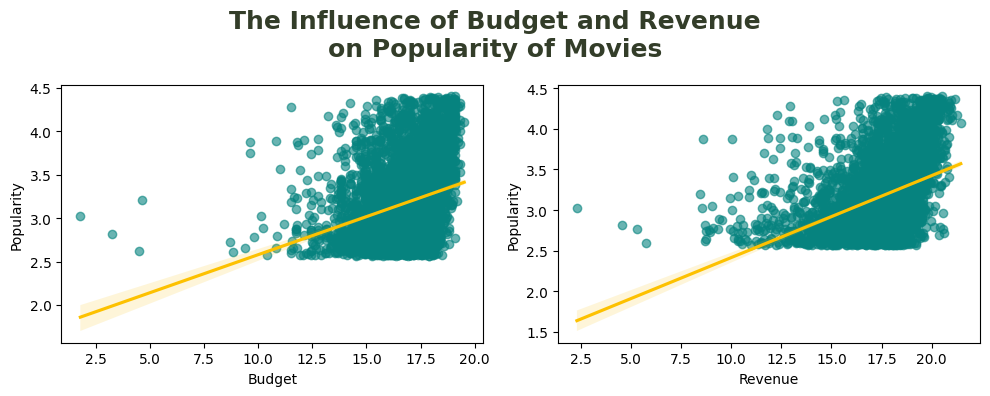

In [125]:
df_plot = df[(df['Budget'] != 0) & (df['Revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['Budget', 'Revenue']):
    sns.regplot(data=df_plot, x=col, y='Popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

In [126]:
df['Genres'].fillna('', inplace=True)

(-1.25, 1.25, -1.25, 1.25)

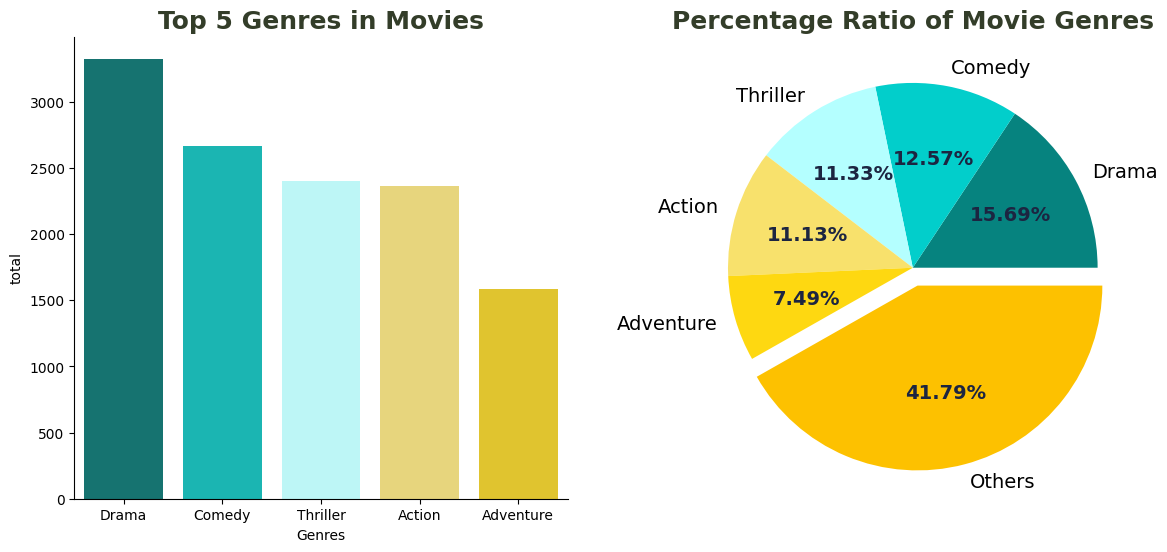

In [127]:
genres_list = []
for i in df['Genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['Genres', 'total'])
ax = sns.barplot(data=df_plot, x='Genres', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'Genres': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['Genres'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

In [128]:
df.columns

Index(['OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Genres', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa\r\r'],
      dtype='object')

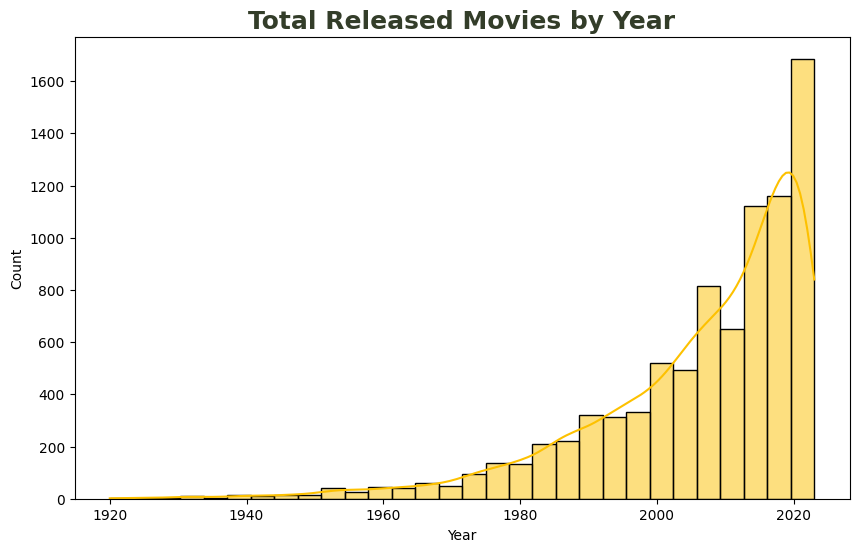

In [129]:
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])

# Extract the year from the 'ReleaseDate' column
df['Year'] = df['ReleaseDate'].dt.year

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Year', kde=True, color='#fdc100', bins=30)
plt.title('Total Released Movies by Year', fontsize=18, weight=600, color='#333d29')
plt.show()

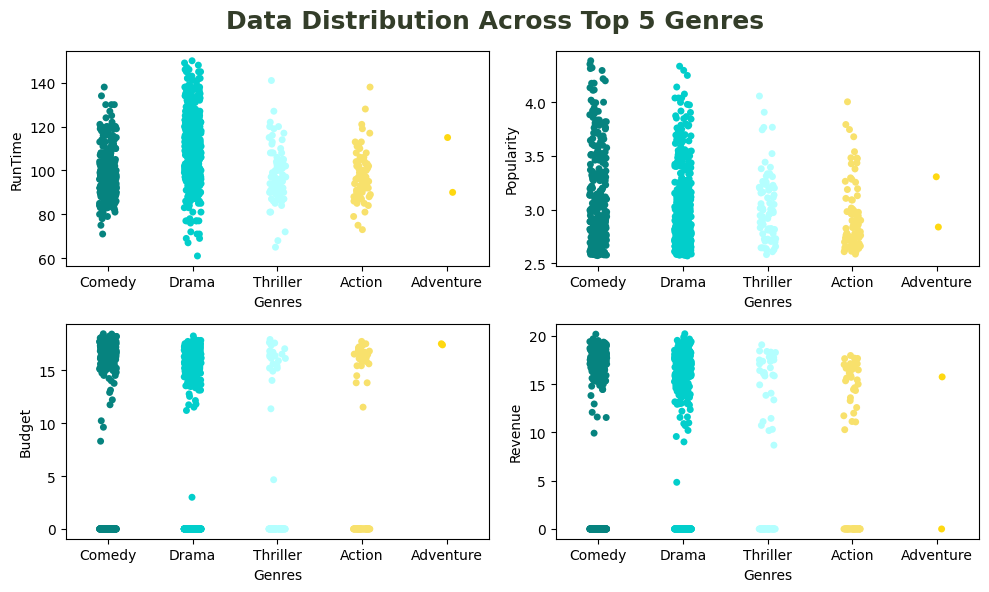

In [130]:
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['Genres', 'total'])
df_plot = df[df['Genres'].isin(df_plot['Genres'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['RunTime', 'Popularity', 'Budget', 'Revenue']):
    sns.stripplot(data=df_plot, x='Genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()

In [131]:
df.columns

Index(['OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Genres', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa\r\r', 'Year'],
      dtype='object')

# Recommendation System

In [132]:
R = df['VoteAverage']
v = df['VoteCount']
# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = df['VoteCount'].quantile(0.8)
C = df['VoteAverage'].mean()

df['weighted_average'] = (R*v + C*m)/(v+m)

In [133]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['Popularity', 'weighted_average'])

weighted_df.index = df['OriginalTitle']

In [134]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['Popularity'].astype('float64')*0.6

In [135]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,Popularity,weighted_average,score
OriginalTitle,,,
Inception,1.000000,0.989986,0.995994
The Matrix,0.996051,0.931687,0.970305
Back to the Future,0.980262,0.952154,0.969018
Whiplash,0.937110,0.971313,0.950791
기생충,0.896571,1.000000,0.937943
Alien,0.961092,0.895790,0.934971
The Help,0.942453,0.909310,0.929196
신과함께-죄와 벌,0.989637,0.837003,0.928584
The Truman Show,0.945670,0.900144,0.927460


In [136]:
hybrid_df = df[['OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Genres', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa\r\r', 'Year']]

In [137]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    if isinstance(text, str):  # Check if the input is a string
        return text.translate(str.maketrans('', '', string.punctuation)).lower()
    else:
        return str(text)  # Convert non-string values to string (including NaN)

# Apply the function to your DataFrame columns
columns_to_clean = ['Genres', 'Overview', 'TagLine']

for column in columns_to_clean:
    hybrid_df[column] = hybrid_df[column].apply(remove_punc)

# Now, create the 'bag_of_words' column
hybrid_df['bag_of_words'] = hybrid_df[columns_to_clean].apply(lambda x: ' '.join(x), axis=1)

# Set 'OriginalTitle' as the index
hybrid_df.set_index('OriginalTitle', inplace=True)

# Keep only the 'bag_of_words' column
hybrid_df = hybrid_df[['bag_of_words']]

# Display the updated DataFrame
hybrid_df.head()

,bag_of_words
OriginalTitle,
Inception,action sciencefiction adventure skilled thief ...
Black Widow,action adventure sciencefiction also known bla...
The Matrix,action sciencefiction century matrix tell stor...
정이,sciencefiction uninhabitable earth outcome civ...
Trolls World Tour,family animation comedy fantasy adventure musi...


In [138]:
hybrid_df = weighted_df_sorted[:10000].merge(hybrid_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(hybrid_df['bag_of_words'])
tfidf_matrix.shape

(9058, 5129)

In [139]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(9058, 9058)

In [140]:
hybrid_df

,Popularity,weighted_average,score,bag_of_words
OriginalTitle,,,,
#살아있다,0.419419,0.675587,0.521886,horror action adventure thriller grisly virus ...
'71,0.041110,0.563922,0.250235,thriller action drama war young soldier must f...
'Twas the Text Before Christmas,0.585622,0.507541,0.554389,tvmovie comedy romance new york city chiroprac...
(500) Days of Summer,0.653515,0.694107,0.669752,comedy drama romance writer hopeless romantic ...
*batteries not included,0.161714,0.520751,0.305329,sciencefiction comedy family fantasy soon bloc...
...,...,...,...,...
화려한 외출,0.357039,0.558124,0.437473,romance drama comedy popular song writer run b...
후궁: 제왕의 첩,0.484247,0.436630,0.465200,drama living torturous life poverty barely abl...
（秘）女郎責め地獄,0.384798,0.487624,0.425929,drama story courtesan popular reason three cus...


In [141]:
hybrid_df.reset_index()

,OriginalTitle,Popularity,weighted_average,score,bag_of_words
0,#살아있다,0.419419,0.675587,0.521886,horror action adventure thriller grisly virus ...
1,'71,0.041110,0.563922,0.250235,thriller action drama war young soldier must f...
2,'Twas the Text Before Christmas,0.585622,0.507541,0.554389,tvmovie comedy romance new york city chiroprac...
3,(500) Days of Summer,0.653515,0.694107,0.669752,comedy drama romance writer hopeless romantic ...
4,*batteries not included,0.161714,0.520751,0.305329,sciencefiction comedy family fantasy soon bloc...
...,...,...,...,...,...
9053,화려한 외출,0.357039,0.558124,0.437473,romance drama comedy popular song writer run b...
9054,후궁: 제왕의 첩,0.484247,0.436630,0.465200,drama living torturous life poverty barely abl...
9055,（秘）女郎責め地獄,0.384798,0.487624,0.425929,drama story courtesan popular reason three cus...
9056,Ｍ家の新妻 変態洗礼,0.589895,0.420982,0.522330,drama romance get married next year live paren...


In [142]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = hybrid_df.reset_index()
    index_movie = data[data['OriginalTitle'] == title].index
    similarity = cos_sim[index_movie].T
    
    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight
    
    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('OriginalTitle', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [143]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = hybrid_df.reset_index()
    index_movie = data[data['OriginalTitle'] == title].index
    
    if not index_movie.empty:
        index_movie = index_movie[0]
        
        sim_scores = list(enumerate(cos_sim[index_movie]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]  # Exclude the movie itself (which will have a similarity of 1.0)

        movie_indices = [i[0] for i in sim_scores]

        recommended_movies = data.iloc[movie_indices]
        recommended_movies['final_score'] = recommended_movies['score'] * (1 - similarity_weight) + \
                                             cos_sim[index_movie, movie_indices] * similarity_weight
        recommended_movies = recommended_movies.sort_values(by='final_score', ascending=False).head(top_n)
        recommended_movies.set_index('OriginalTitle', inplace=True)

        return recommended_movies[['score', 'final_score']]
    else:
        print(f"Movie with title '{title}' not found in the dataset.")
        return None

In [144]:
predict("'Twas the Text Before Christmas", similarity_weight=0.7, top_n=10)

,score,final_score
OriginalTitle,,
Jeune & Jolie,0.538093,0.341694
Holidate,0.410142,0.337362
Old,0.624362,0.336327
Happiest Season,0.358419,0.289902
A Very Harold & Kumar Christmas,0.237001,0.256192
MILF,0.301280,0.240341
Barbie: A Perfect Christmas,0.242650,0.224698
New Year's Eve,0.273785,0.223486
Something from Tiffany's,0.250985,0.222112


In [145]:
hybrid_df.to_csv('hybrid_df.csv')

In [146]:
import pickle
pickle.dump(tfidf_matrix, open('cosine_similarity.pkl', 'wb'))

In [148]:
df.columns

Index(['OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Genres', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa\r\r', 'Year', 'weighted_average'],
      dtype='object')

# Pandas Profiling


In [158]:
from pydantic_settings import BaseSettings
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")
profile.to_file("Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [160]:
hybrid_df.columns

Index(['Popularity', 'weighted_average', 'score', 'bag_of_words'], dtype='object')

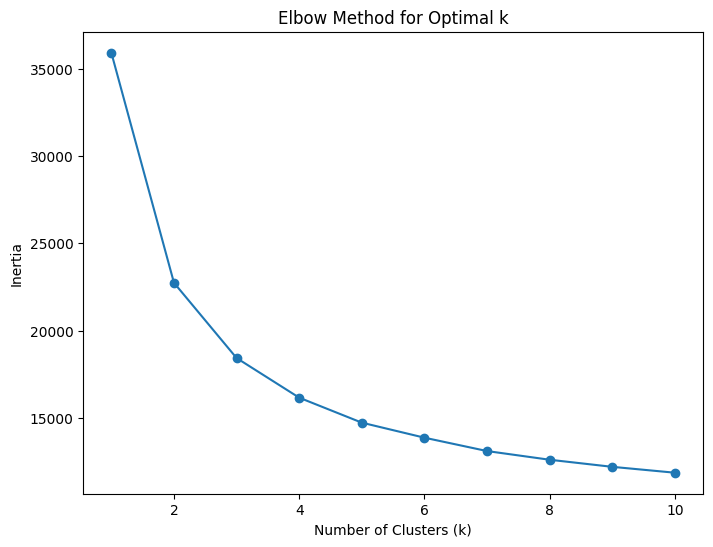

In [181]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

bag_of_words = hybrid_df['bag_of_words'].values

numerical_features = ['Popularity', 'weighted_average', 'score']
X_numerical = hybrid_df[numerical_features].values

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(bag_of_words)

scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

X_combined = hstack((X_tfidf, X_numerical_scaled))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined.toarray())

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

inertia = []

max_k = 10
for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_combined)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k+1), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [202]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

bag_of_words = hybrid_df['bag_of_words'].values

numerical_features = ['Popularity', 'weighted_average', 'score']
X_numerical = hybrid_df[numerical_features].values

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(bag_of_words)

scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

X_combined = hstack((X_tfidf, X_numerical_scaled))

k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(X_combined)

hybrid_df['Cluster'] = clusters

hybrid_df[['bag_of_words', 'Cluster']]

,bag_of_words,Cluster
0,horror action adventure thriller grisly virus ...,2
1,thriller action drama war young soldier must f...,1
2,tvmovie comedy romance new york city chiroprac...,2
3,comedy drama romance writer hopeless romantic ...,2
4,sciencefiction comedy family fantasy soon bloc...,1
...,...,...
9053,romance drama comedy popular song writer run b...,1
9054,drama living torturous life poverty barely abl...,2
9055,drama story courtesan popular reason three cus...,1
9056,drama romance get married next year live paren...,2


In [171]:
hybrid_df.reset_index(drop=True, inplace=True)

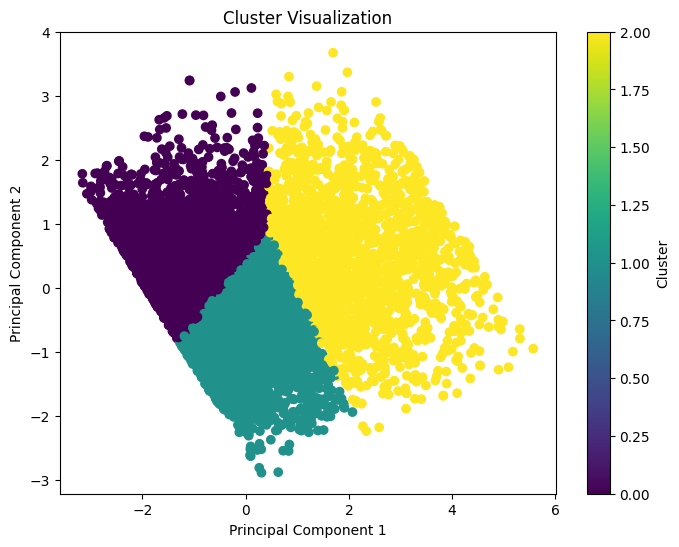

In [180]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined.toarray())

# Create a DataFrame for the reduced dimensions
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Add cluster labels
pca_df['Cluster'] = hybrid_df['Cluster']

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [186]:
# Define a range of values for eps and min_samples
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 20]

best_eps = None
best_min_samples = None
best_silhouette = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_combined)
        if len(set(clusters)) > 1:  # Ensure more than one cluster is formed
            silhouette = silhouette_score(X_combined, clusters)
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_eps = eps
                best_min_samples = min_samples

print(f'Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_silhouette}')

Best eps: 1.0, Best min_samples: 5, Best Silhouette Score: -0.1579273504891262


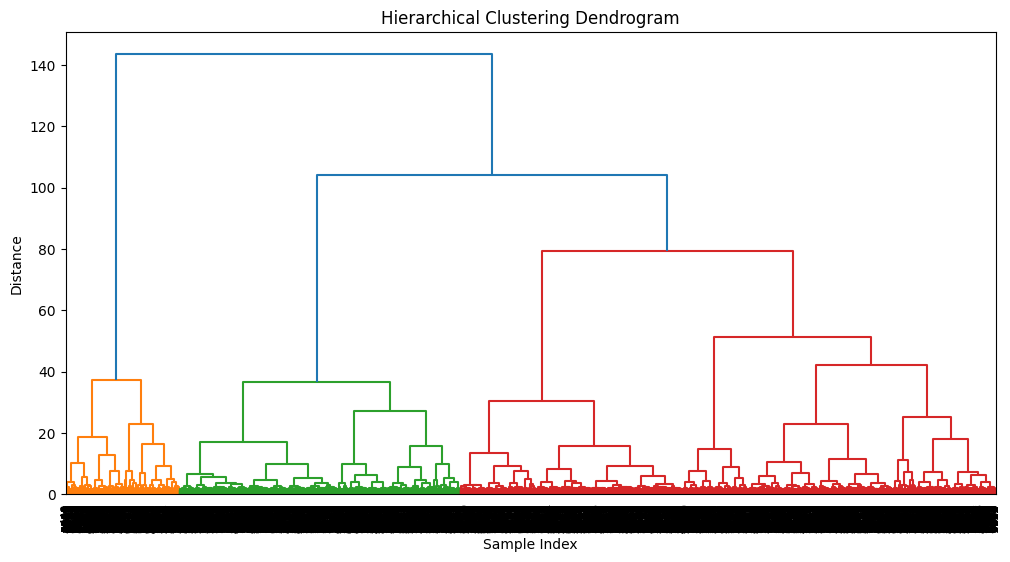

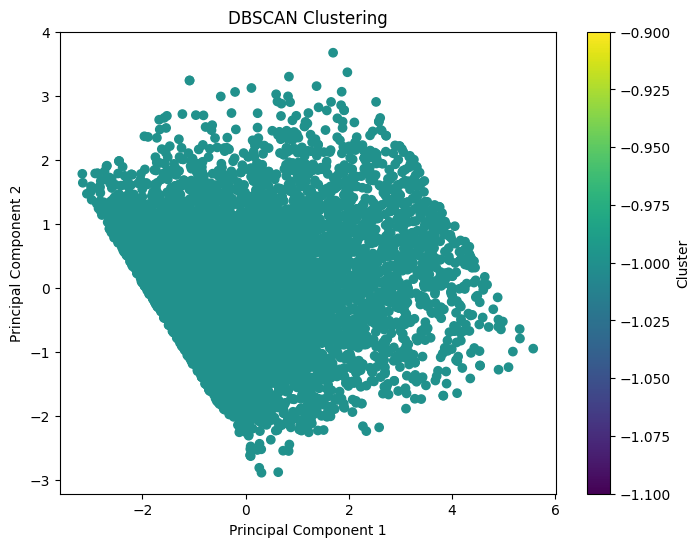

In [187]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

bag_of_words = hybrid_df['bag_of_words'].values

numerical_features = ['Popularity', 'weighted_average', 'score']
X_numerical = hybrid_df[numerical_features].values

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(bag_of_words)

scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

X_combined = hstack((X_tfidf, X_numerical_scaled))

Z = linkage(X_combined.toarray(), method='ward')

plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_combined)

hybrid_df['Cluster'] = clusters

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [196]:
df.head()

,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,TagLine,...,Revenue,Genres,North America,Europe,Asia,Oceania,South America,Africa\r\r,Year,weighted_average
Id,,,,,,,,,,,,,,,,,,,,,
27205,1,Inception,skilled thief corporate espionage subconscious...,4.401216,2010-07-15,Inception,8.4,10.452418,18.890684,Your mind is the scene of the crime.,...,20.531540,"Action, ScienceFiction, Adventure",1,1,0,0,0,0,2010,7.611165
497698,1,Black Widow,also known black widow part ledger dangerous c...,4.399596,2021-07-07,Black Widow,7.3,9.142918,19.113828,Her world. Her secrets. Her legacy.,...,19.755027,"Action, Adventure, ScienceFiction",1,0,0,0,0,0,2021,6.951345
603,1,The Matrix,century matrix tell story computer hacker join...,4.393980,1999-03-30,The Matrix,8.2,10.084350,17.958645,Welcome to the Real World.,...,19.954354,"Action, ScienceFiction",1,0,0,0,0,0,1999,7.481176
843794,0,정이,uninhabitable earth outcome civil war hinge br...,4.393819,2023-01-12,JUNG_E,6.2,6.238325,0.000000,AI Combat Warrior Will be Unleashed.,...,0.000000,ScienceFiction,0,0,1,0,0,0,2023,6.384944
446893,1,Trolls World Tour,queen poppy branch make surprising discovery —...,4.393436,2020-03-11,Trolls World Tour,7.3,7.567346,18.315320,Happiest. Movie. Ever.,...,17.712964,"Family, Animation, Comedy, Fantasy, Adventure,...",1,0,0,0,0,0,2020,6.915282


In [197]:
df.columns

Index(['OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Genres', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa\r\r', 'Year', 'weighted_average'],
      dtype='object')

In [200]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["Title"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

NameError: name 'movies' is not defined

In [198]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["Title"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["OriginalTitle"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("Popularity")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [199]:
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

model.fit(cached_train, epochs=3)

NameError: name 'unique_movie_titles' is not defined